In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nri-by-county/National_Risk_Index_Counties_807384124455672111.csv


In [2]:
import pandas as pd, json
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings("ignore")

# Show all columns without truncation
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

In [3]:
INPUT_CSV_PATH = "/kaggle/input/nri-by-county/National_Risk_Index_Counties_807384124455672111.csv"  
OUTPUT_CSV_PATH = "/kaggle/working/nri_counties_clean.csv"

In [4]:
df = pd.read_csv(INPUT_CSV_PATH)

In [5]:
df.shape

(3231, 468)

In [6]:
for col in df.columns:
    print(col)

OBJECTID
National Risk Index ID
State Name
State Name Abbreviation
State FIPS Code
County Name
County Type
County FIPS Code
State-County FIPS Code
Population (2020)
Building Value ($)
Agriculture Value ($)
Area (sq mi)
National Risk Index - Value - Composite
National Risk Index - Score - Composite
National Risk Index - Rating - Composite
National Risk Index - State Percentile - Composite
Expected Annual Loss - Score - Composite
Expected Annual Loss - Rating - Composite
Expected Annual Loss - State Percentile - Composite
Expected Annual Loss - Total - Composite
Expected Annual Loss - Building Value - Composite
Expected Annual Loss - Population - Composite
Expected Annual Loss - Population Equivalence - Composite
Expected Annual Loss - Agriculture Value - Composite
Expected Annual Loss Rate - Building - Composite
Expected Annual Loss Rate - Population - Composite
Expected Annual Loss Rate - Agriculture - Composite
Expected Annual Loss Rate - National Percentile - Composite
Social Vulnera

In [7]:
HAZARDS = [
    "Avalanche","Coastal Flooding","Cold Wave","Drought","Earthquake","Hail",
    "Heat Wave","Hurricane","Ice Storm","Landslide","Lightning","Riverine Flooding",
    "Strong Wind","Tornado","Tsunami","Volcanic Activity","Wildfire","Winter Weather"
]

In [8]:
EAL_TOTAL = {h: f"{h} - Expected Annual Loss - Total" for h in HAZARDS}

In [9]:
HAZARDS = sorted(HAZARDS)  # alphabetical on y-axis
haz2y = {h: i for i, h in enumerate(HAZARDS)}

In [10]:
state_fips = (
    df["State FIPS Code"]
    .astype("Int64").astype(str).str.replace("<NA>","", regex=False).str.zfill(2)
)
county3 = (
    df["County FIPS Code"]
    .astype("Int64").astype(str).str.replace("<NA>","", regex=False).str.zfill(3)
)

df["state_fips"] = state_fips
df["county_fips"] = state_fips + county3   # <- 5-digit GEOID as requested

In [11]:
df["risk_index_score"]  = df["National Risk Index - Score - Composite"]
df["risk_index_rating"] = df["National Risk Index - Rating - Composite"]

In [12]:
# --- Predominant hazard by max EAL-Total across 18 hazards ---
present_cols = [c for c in EAL_TOTAL.values() if c in df.columns]
eal = df[present_cols].astype(float).fillna(-np.inf)
max_col = eal.idxmax(axis=1).where(eal.notna().any(axis=1))
df["predominant_hazard"] = (
    max_col.fillna("Unknown").str.split(" - ", n=1).str[0]
)

In [13]:
out = df.rename(columns={
    "County Name": "county_name",
    "State Name":  "state_name",
})[[
    "county_fips",          # 5-digit
    "county_name",
    "state_name",
    "state_fips",           # 2-digit
    "risk_index_score",
    "risk_index_rating",
    "predominant_hazard",   # <— added
]]

# Ensure types that play nice with Supabase (keep FIPS as text to preserve zeros)
out["county_fips"] = out["county_fips"].astype(str).str.zfill(5)
out["state_fips"]  = out["state_fips"].astype(str).str.zfill(2)
out["risk_index_score"] = pd.to_numeric(out["risk_index_score"], errors="coerce")

In [14]:
out.to_csv(OUTPUT_CSV_PATH, index=False)
print("Saved:", OUTPUT_CSV_PATH , "Rows:", len(out), "Cols:", out.shape[1])

Saved: /kaggle/working/nri_counties_clean.csv Rows: 3231 Cols: 7


In [15]:
out.shape

(3231, 7)

In [16]:
out.head()

county_fips county_name state_name state_fips  risk_index_score  \
0       01001     Autauga    Alabama         01         49.220490   
1       01003     Baldwin    Alabama         01         97.709195   
2       01005     Barbour    Alabama         01         56.188355   
3       01007        Bibb    Alabama         01         32.484887   
4       01009      Blount    Alabama         01         65.128858   

  risk_index_rating predominant_hazard  
0    Relatively Low            Tornado  
1   Relatively High          Hurricane  
2    Relatively Low          Hurricane  
3          Very Low            Tornado  
4    Relatively Low            Tornado

# Hazard Type Risk Index Value vs Expected Annual Loss – Total

In [17]:
# --- Predominant hazard by *Hazard Type Risk Index Value* ---
RISK_VAL_COLS = {h: f"{h} - Hazard Type Risk Index Value" for h in HAZARDS}
present_riskval_cols = [c for c in RISK_VAL_COLS.values() if c in df.columns]
if len(present_riskval_cols) != len(RISK_VAL_COLS):
    missing_rv = sorted(set(RISK_VAL_COLS.values()) - set(present_riskval_cols))
    if missing_rv:
        print("WARNING: Missing Hazard Type Risk Index Value columns:", missing_rv)

# Coerce to numeric first (so non-numeric cells become NaN)
riskval_numeric = df[present_riskval_cols].apply(pd.to_numeric, errors="coerce")

# Row has at least one valid number?
has_any = riskval_numeric.notna().any(axis=1)

# Use -inf for NaNs so idxmax works, then mask rows with no data
riskval_filled = riskval_numeric.fillna(-np.inf)
rv_max_col = riskval_filled.idxmax(axis=1)

# Extract hazard name (before " - "), but keep "Unknown" where no values existed
df["predominant_hazard_riskindex"] = (
    rv_max_col.where(has_any)                  # NaN if row had no valid values
             .fillna("Unknown")
             .str.split(" - ", n=1)           # <-- key fix: pass n=1 as keyword
             .str[0]
)

state_names = sorted(df["State Name"].unique())
per_state_alignment = []


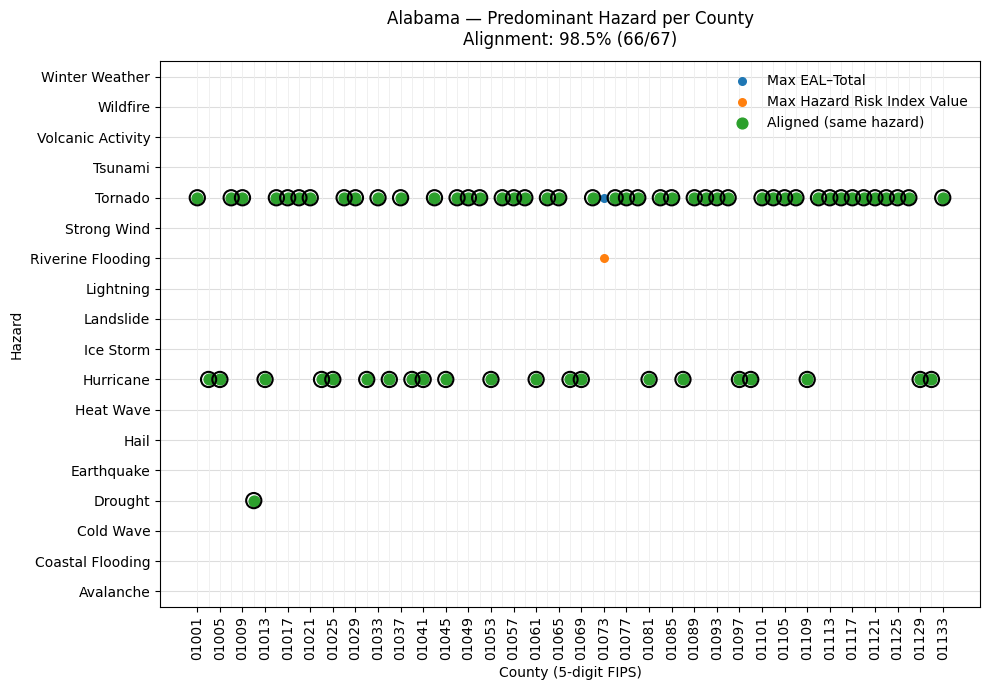

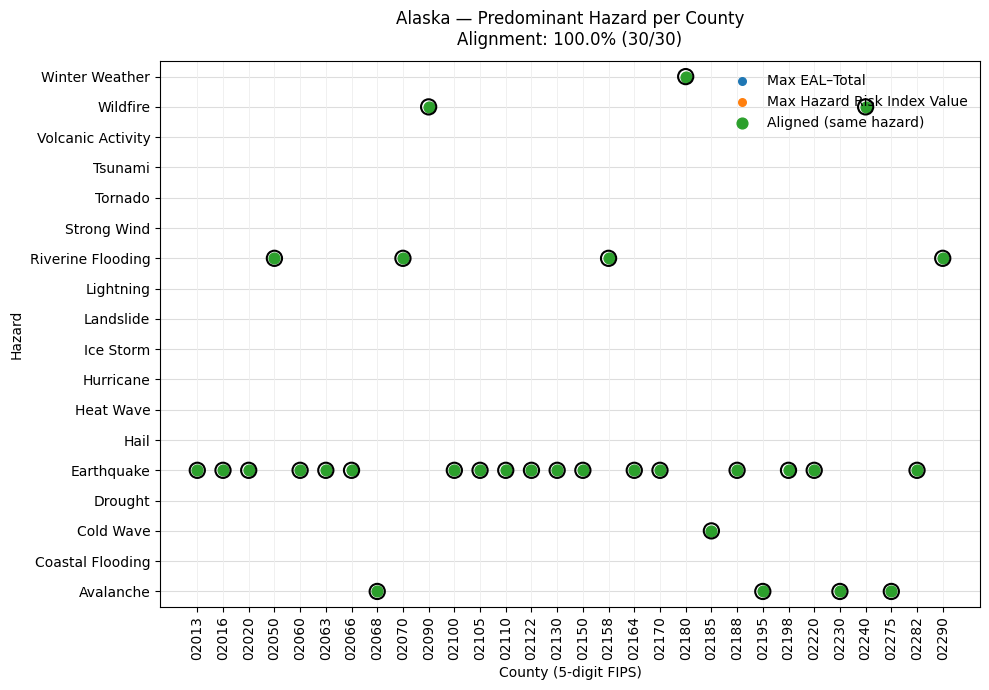

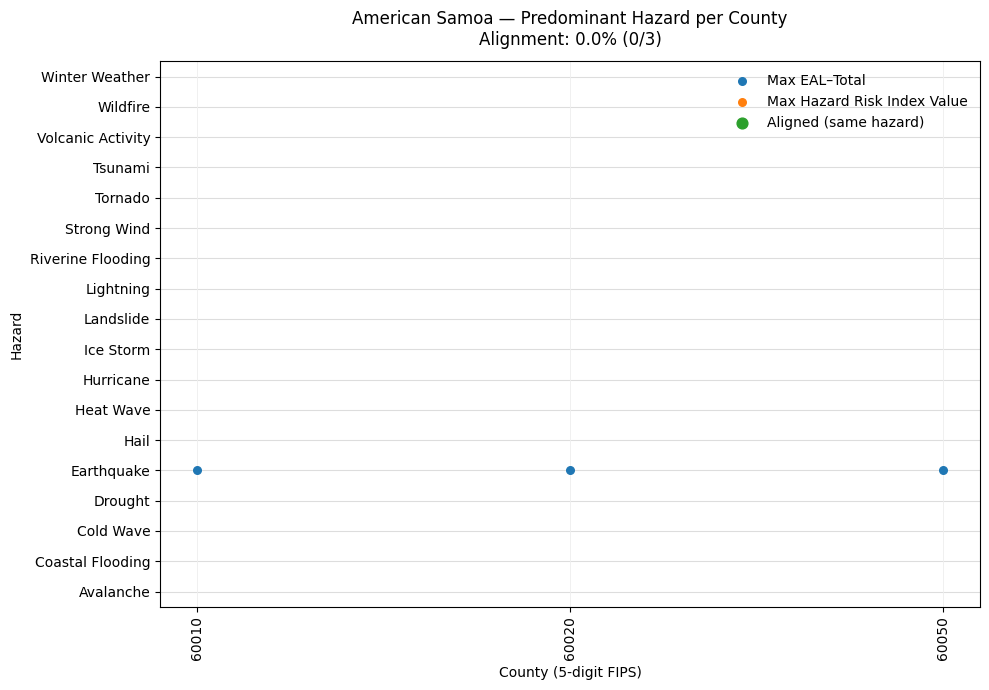

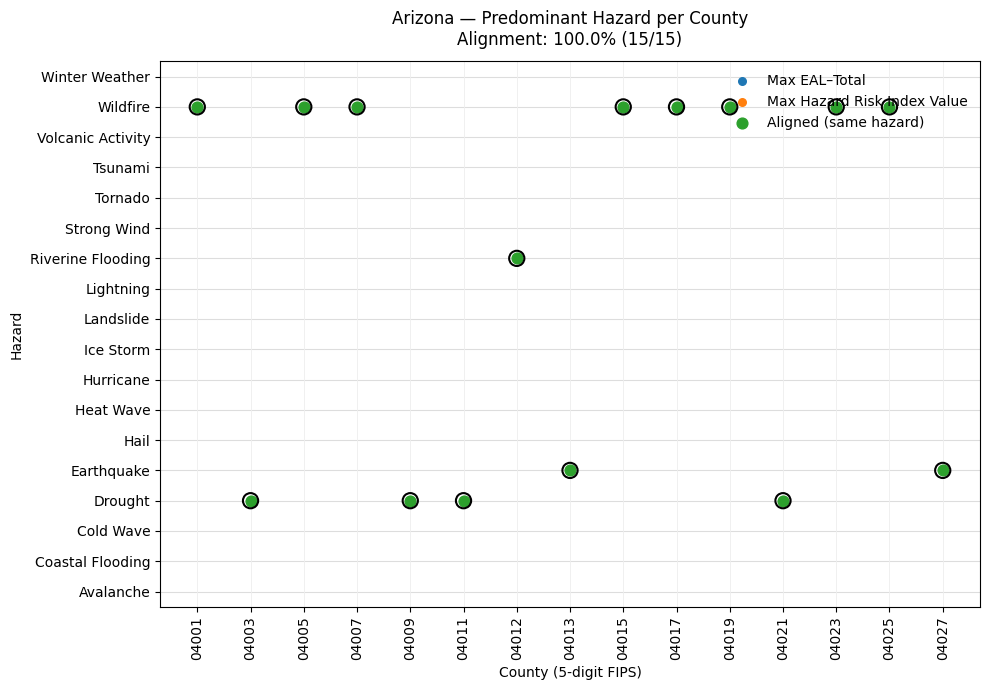

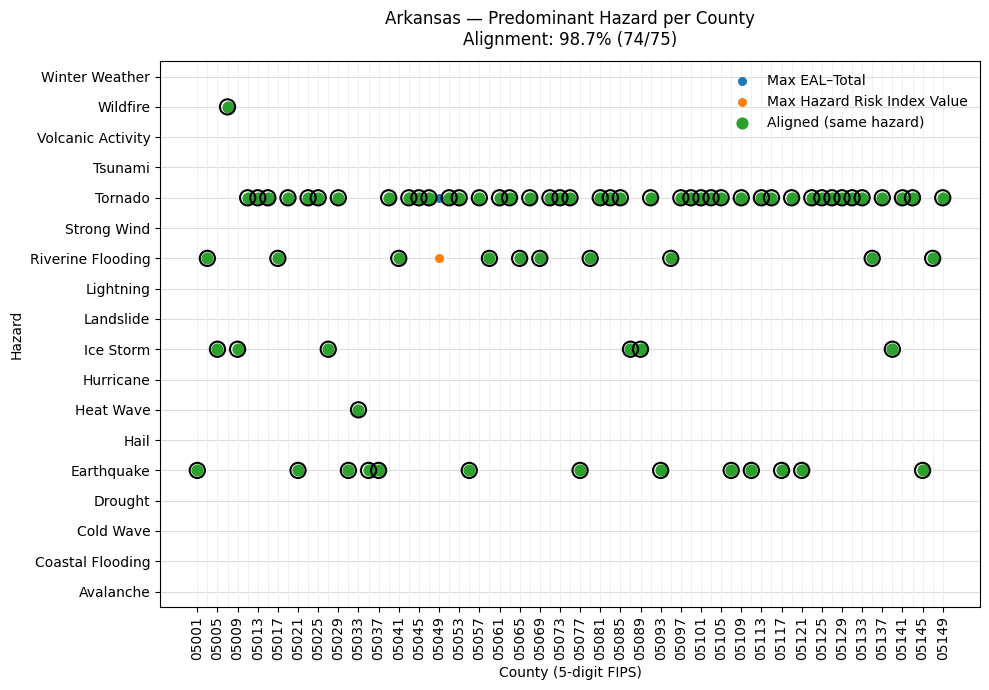

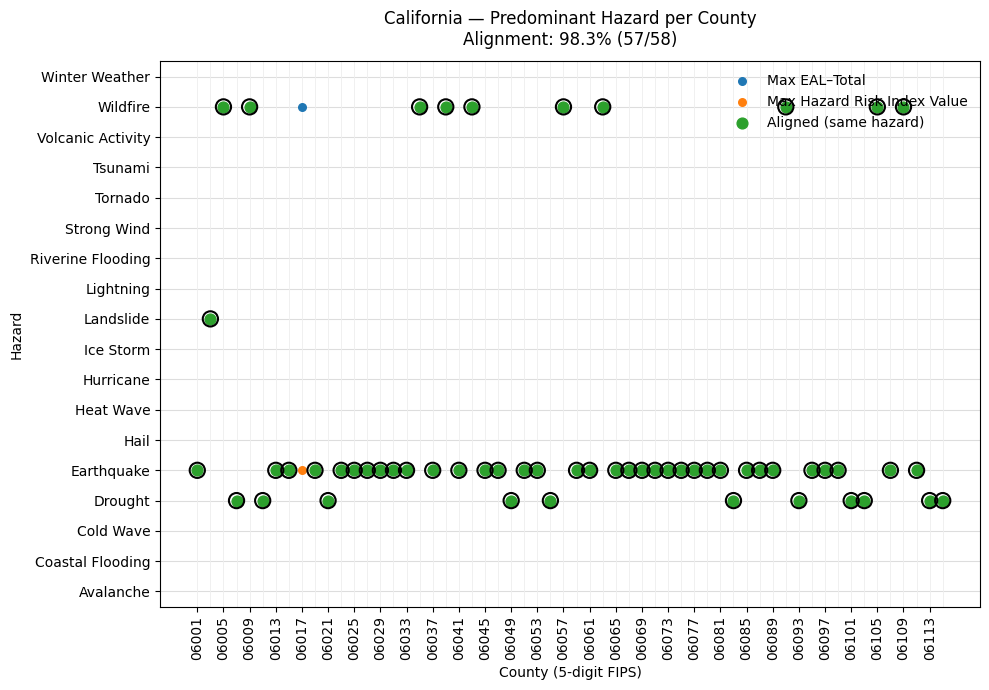

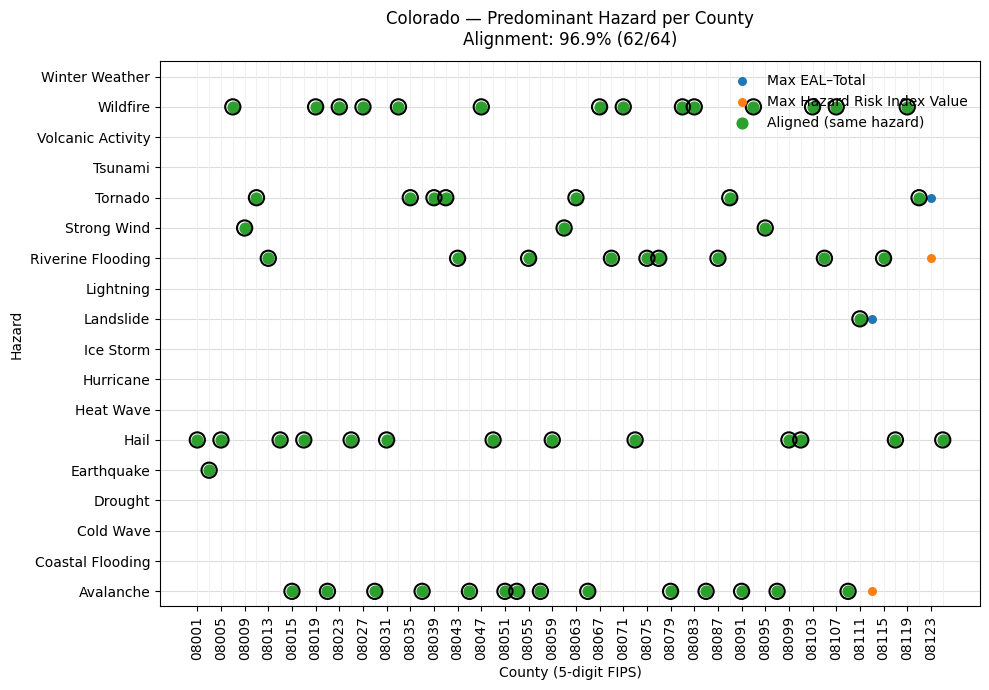

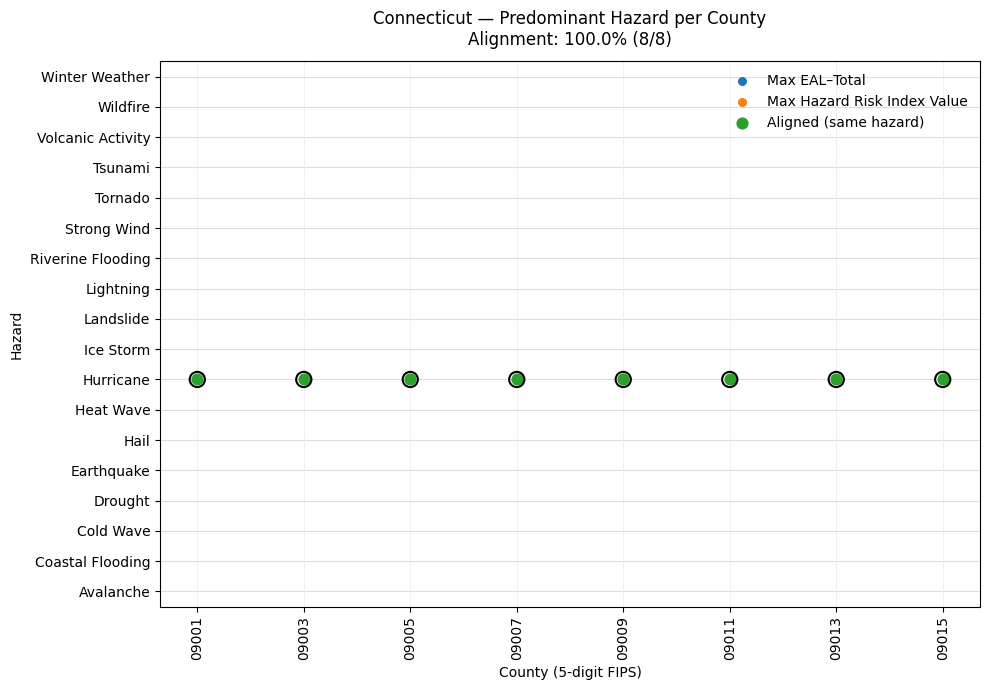

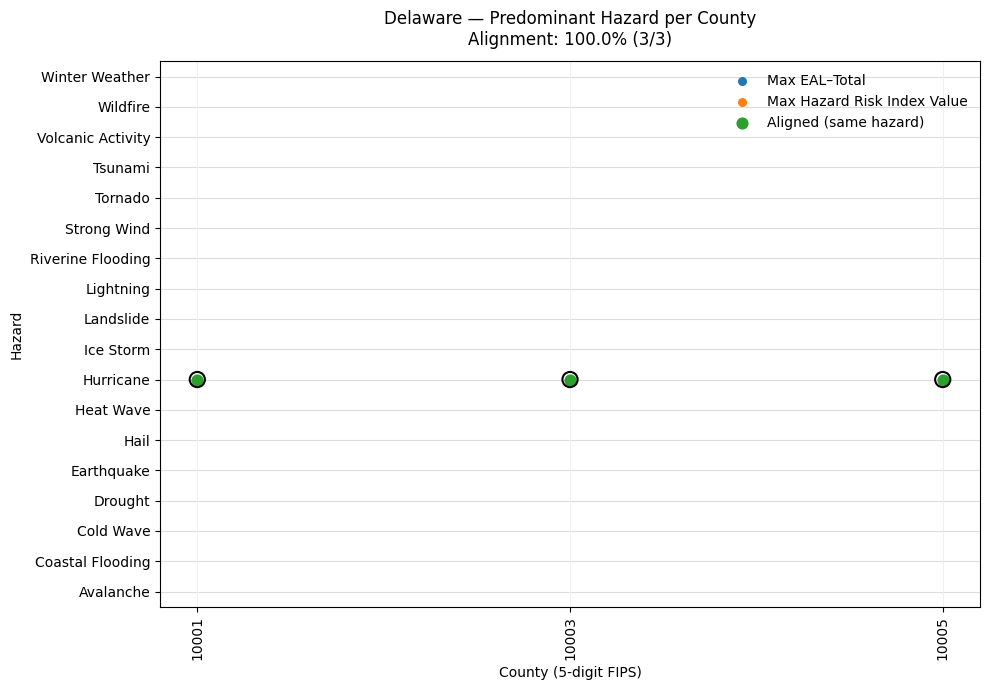

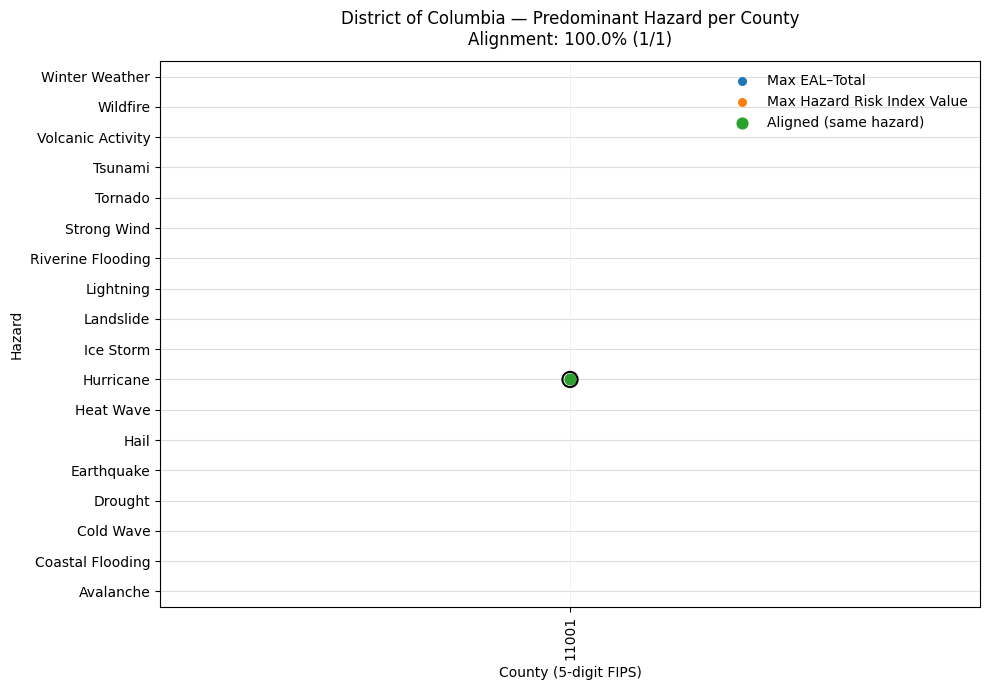

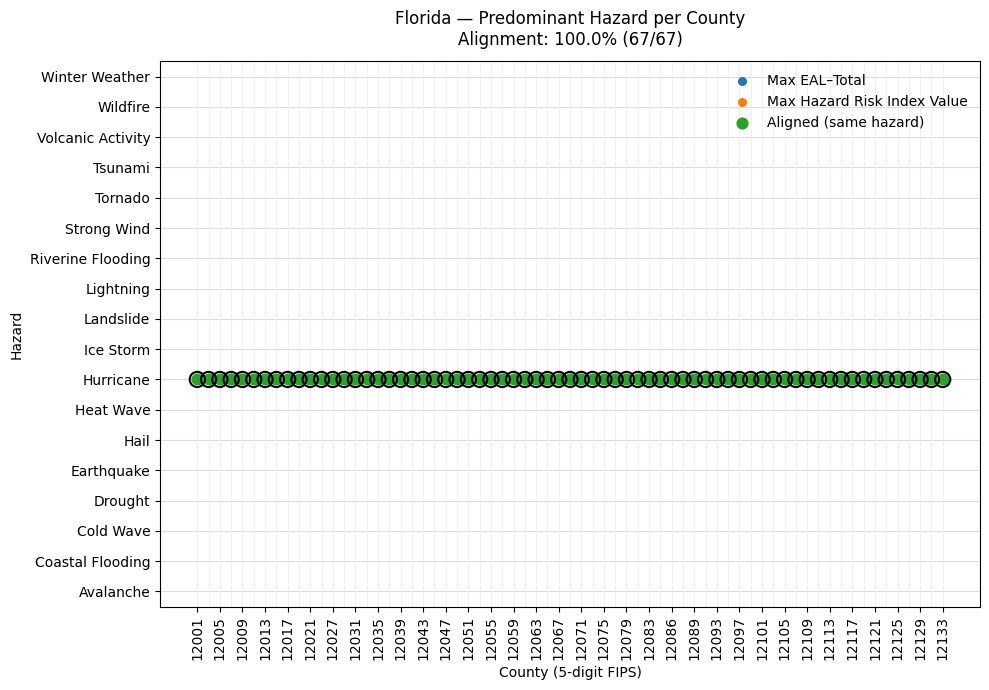

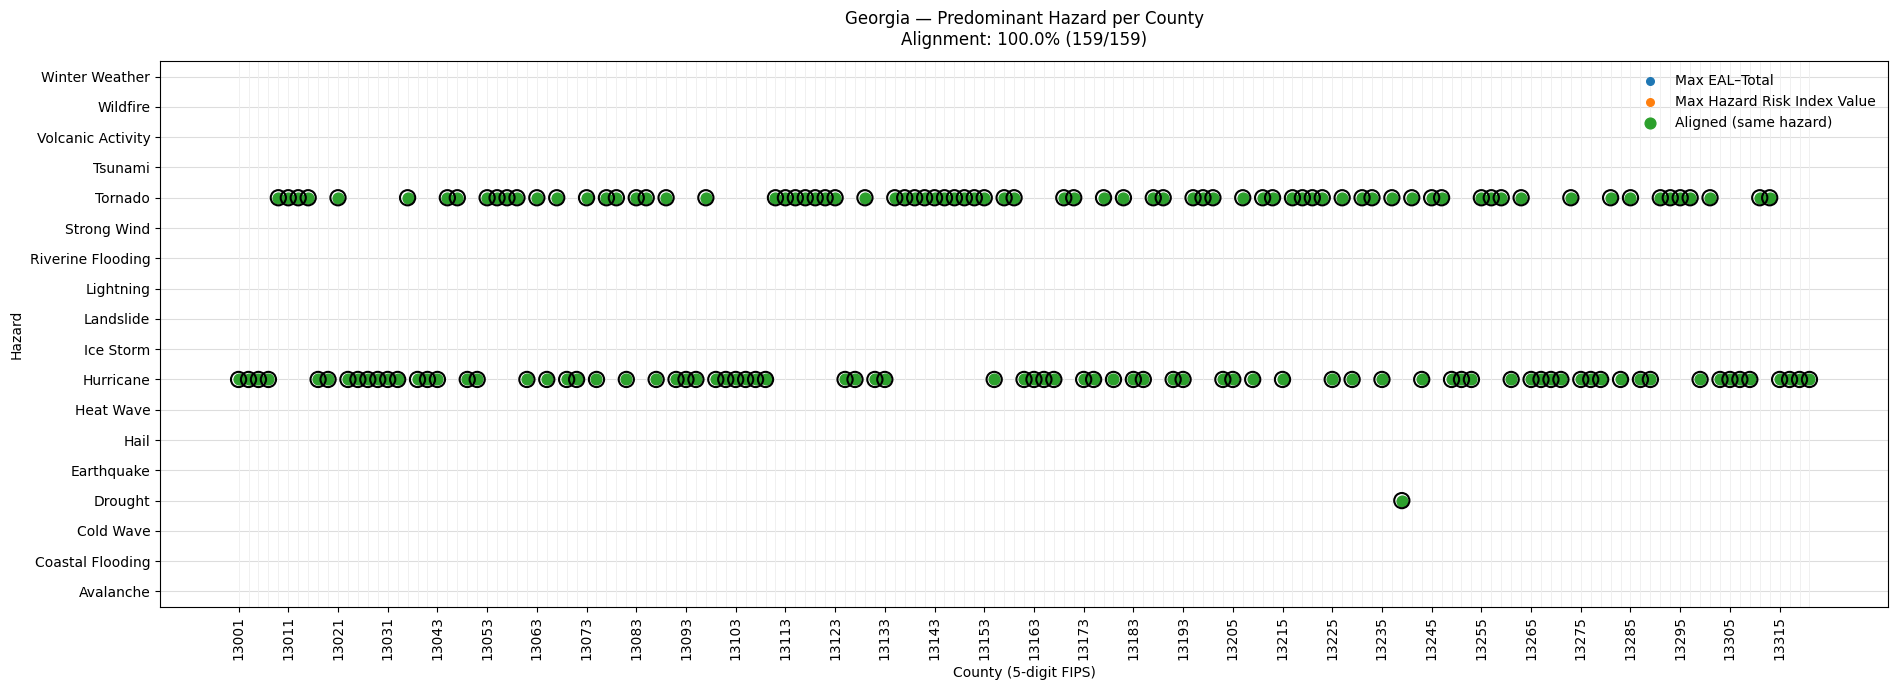

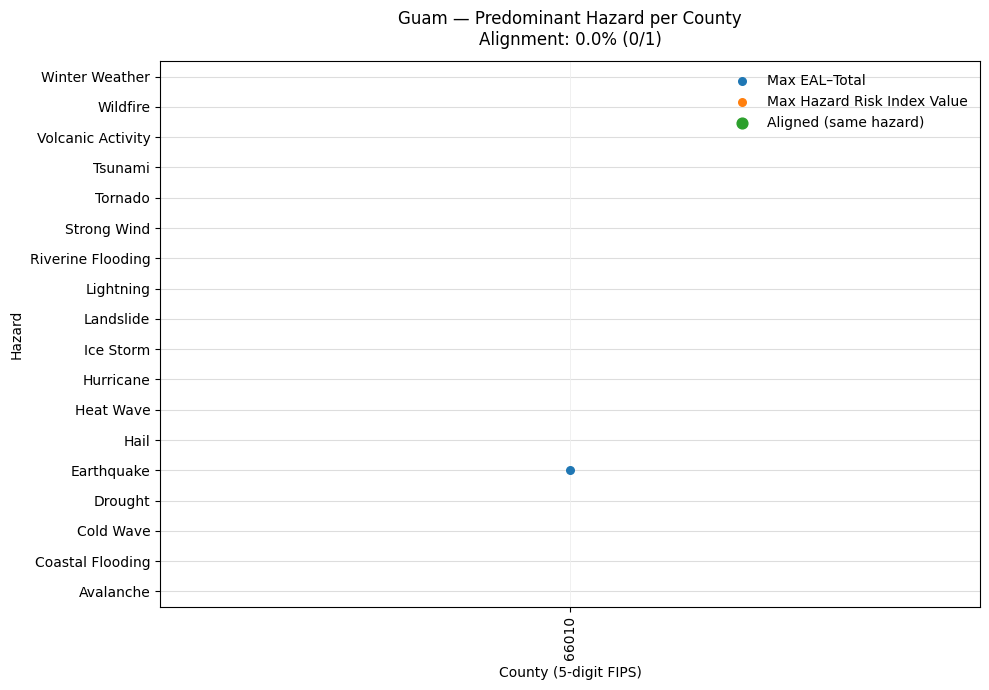

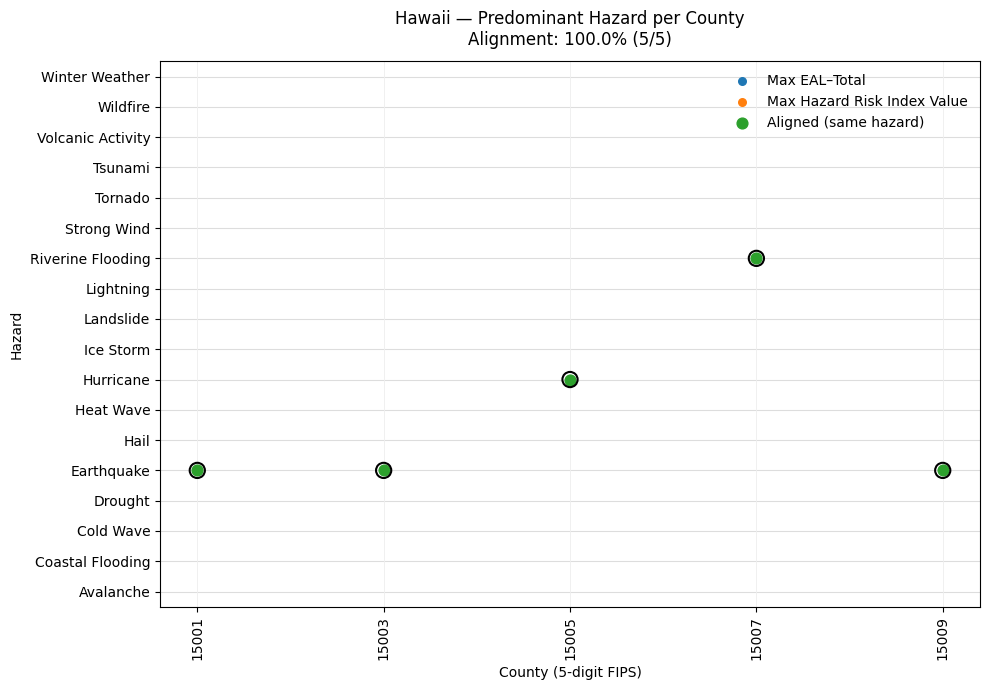

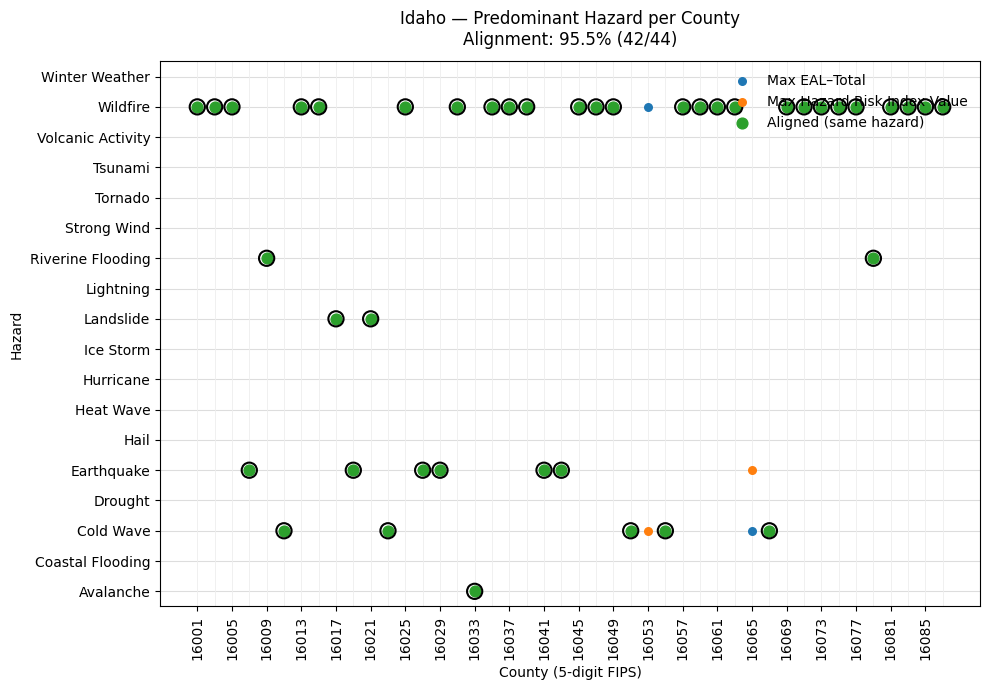

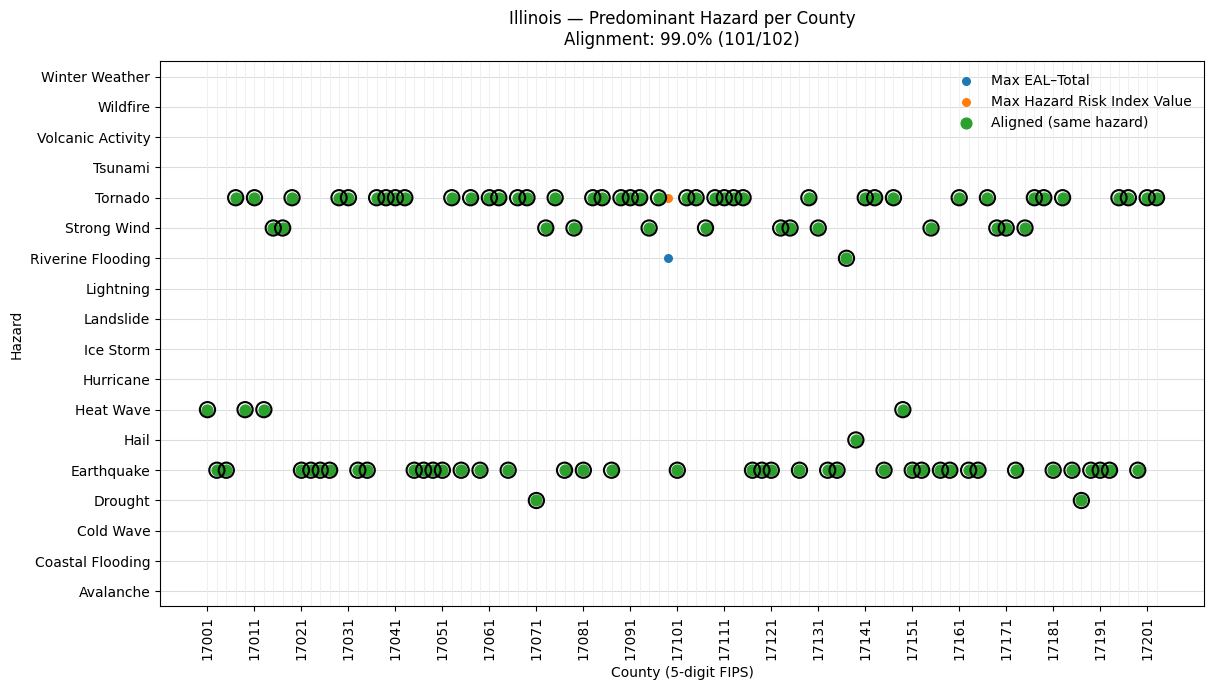

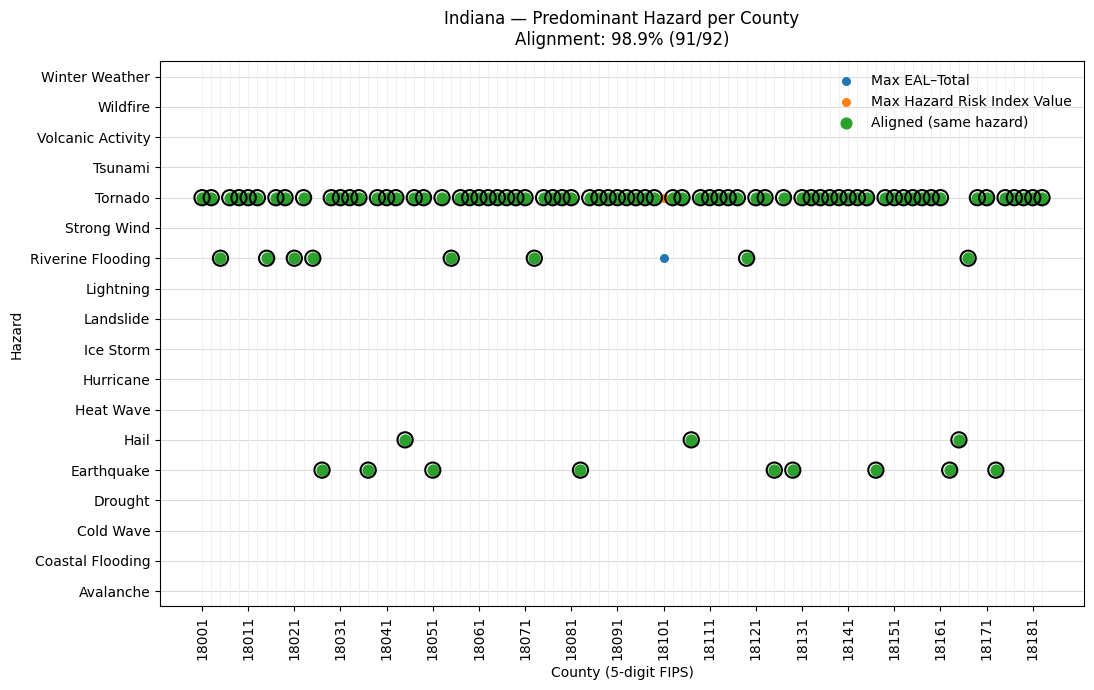

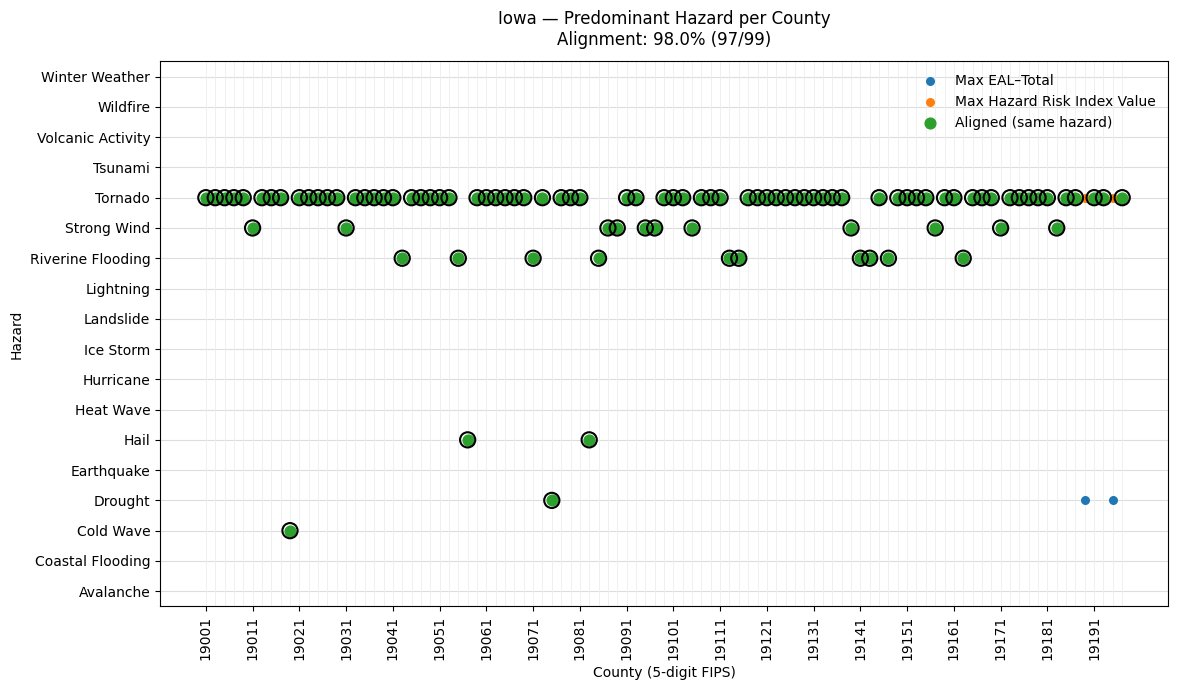

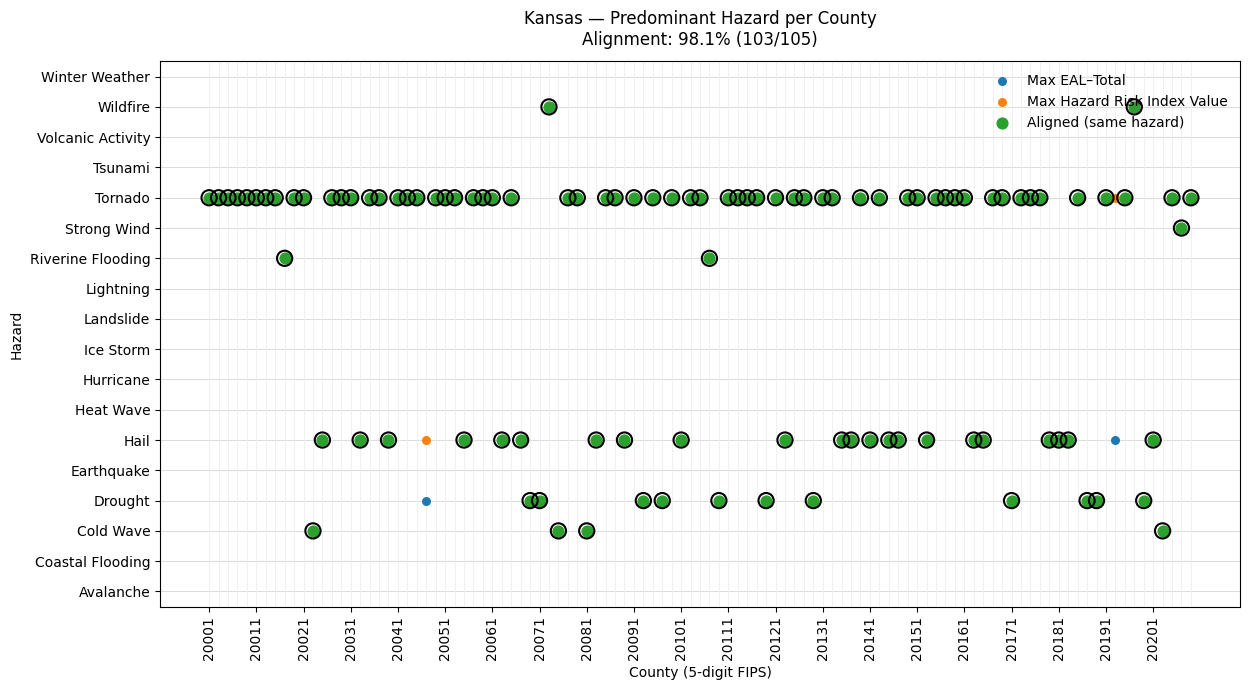

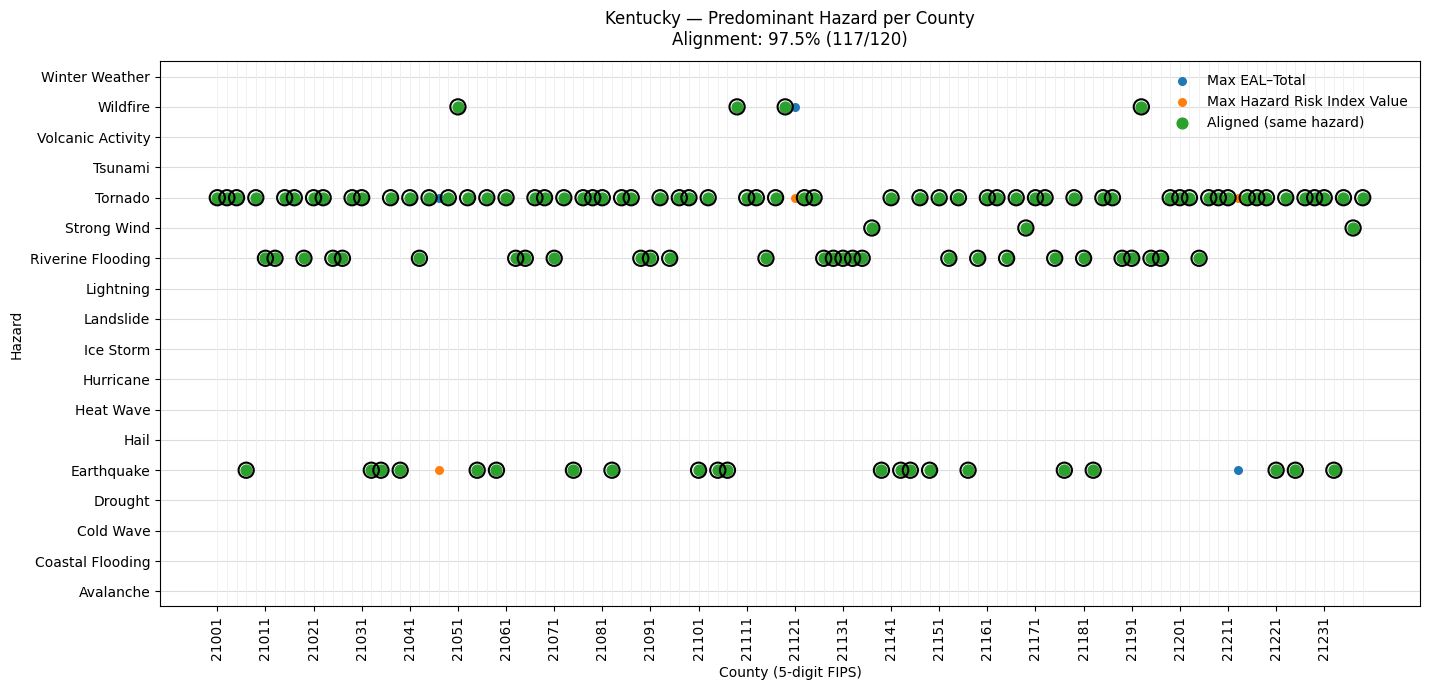

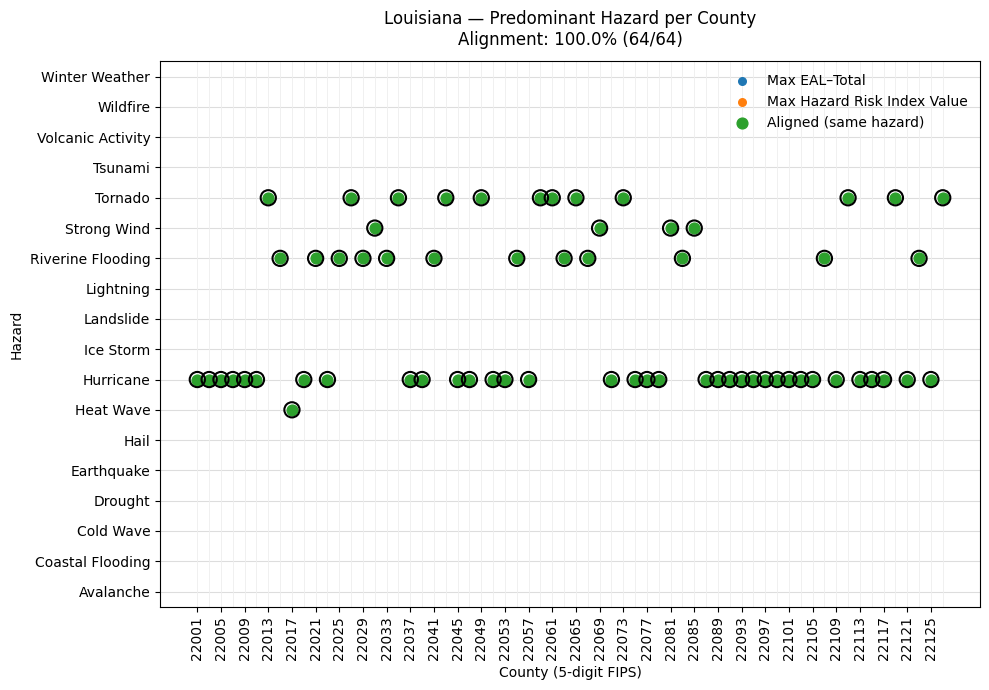

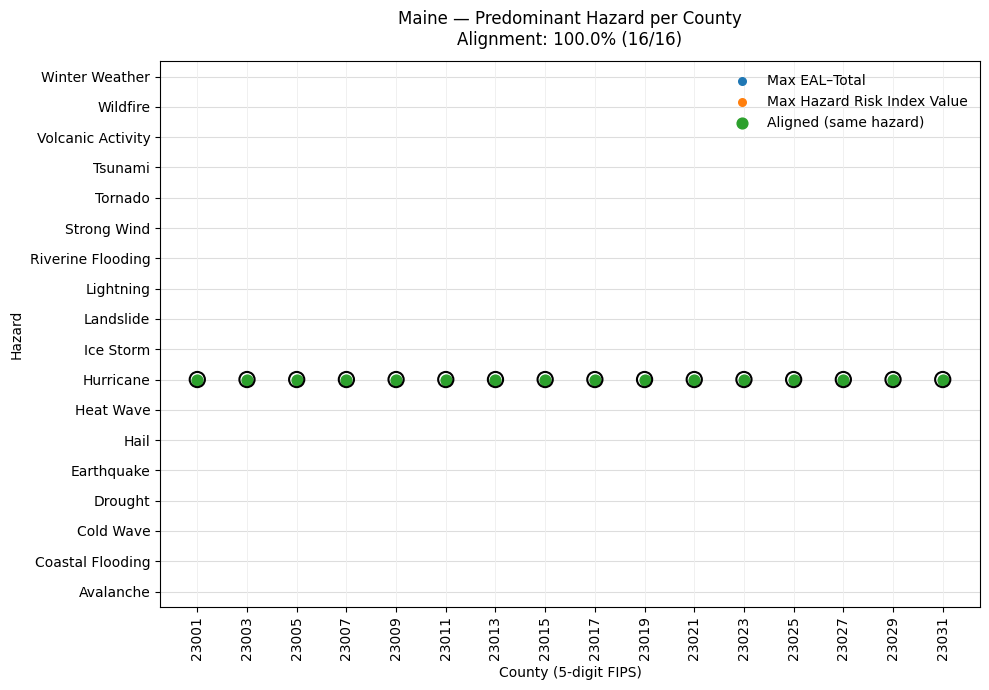

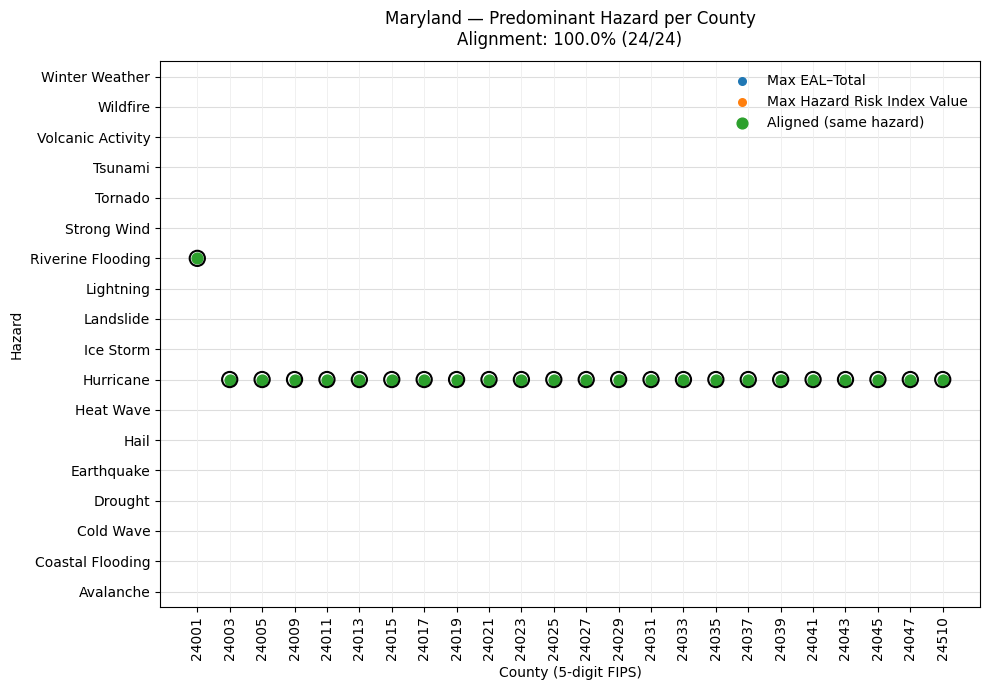

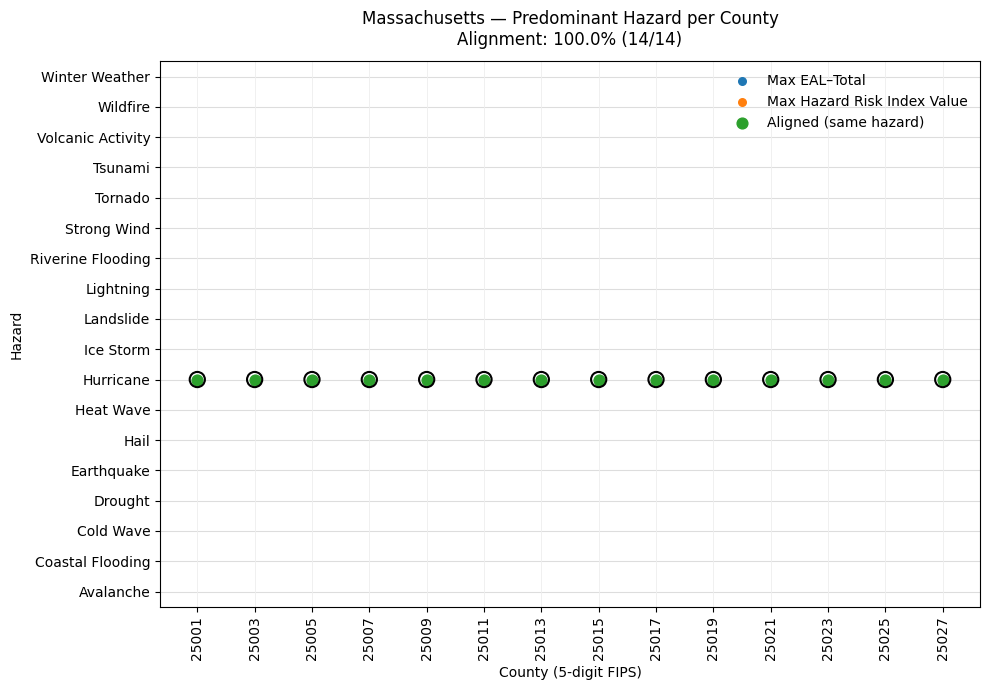

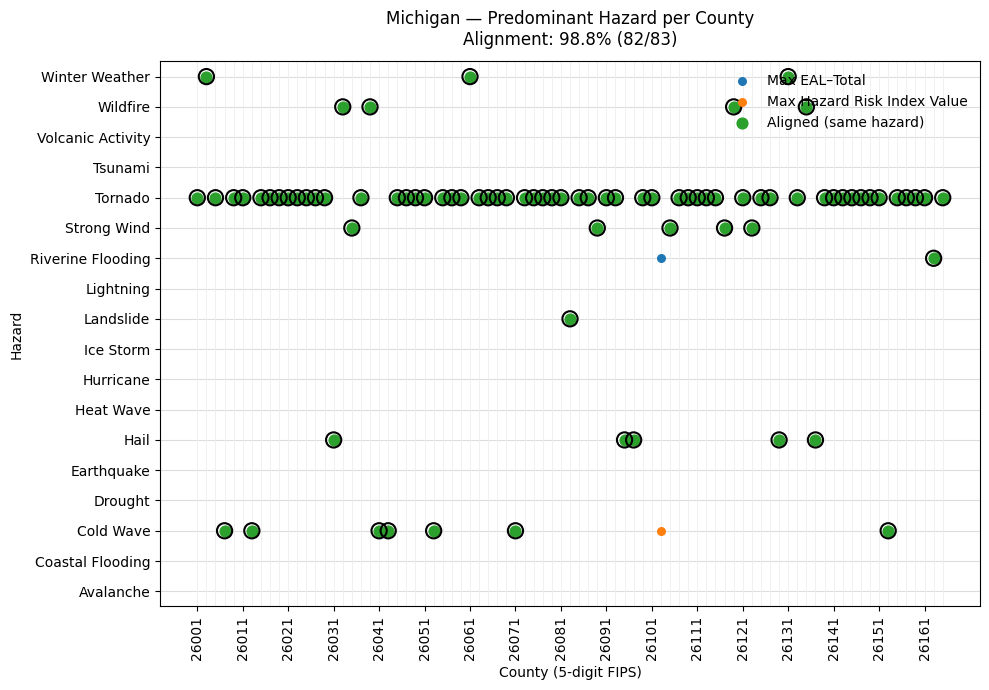

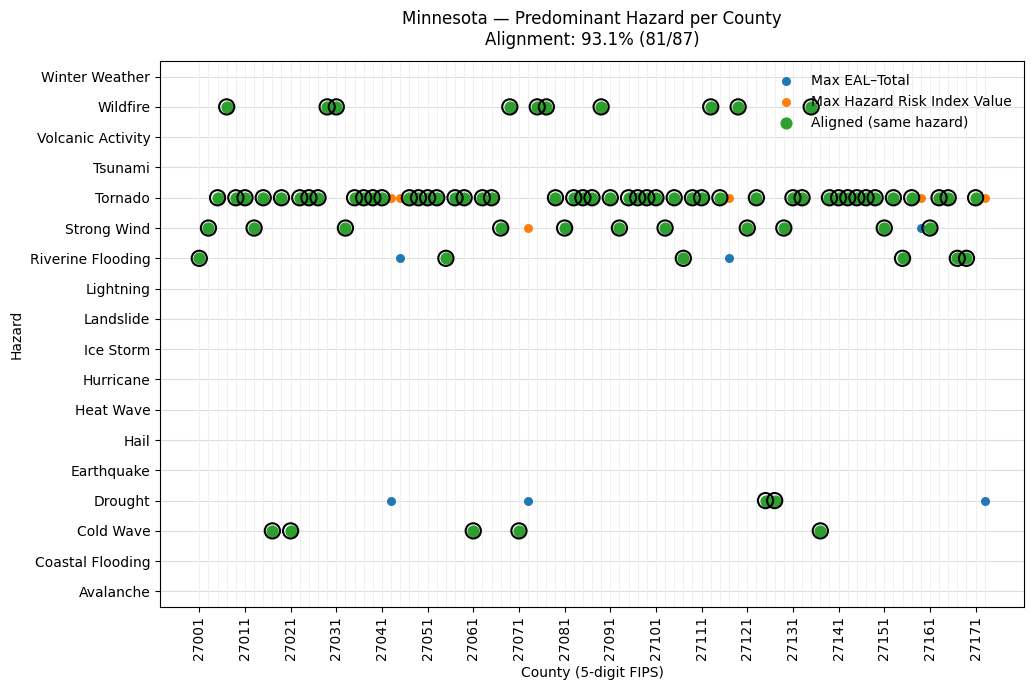

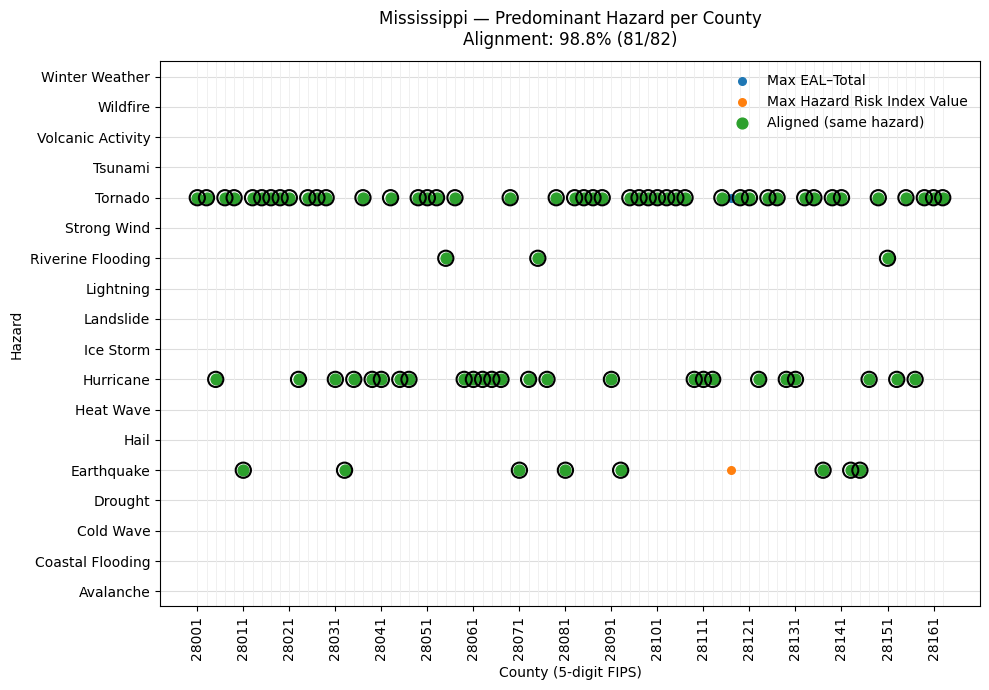

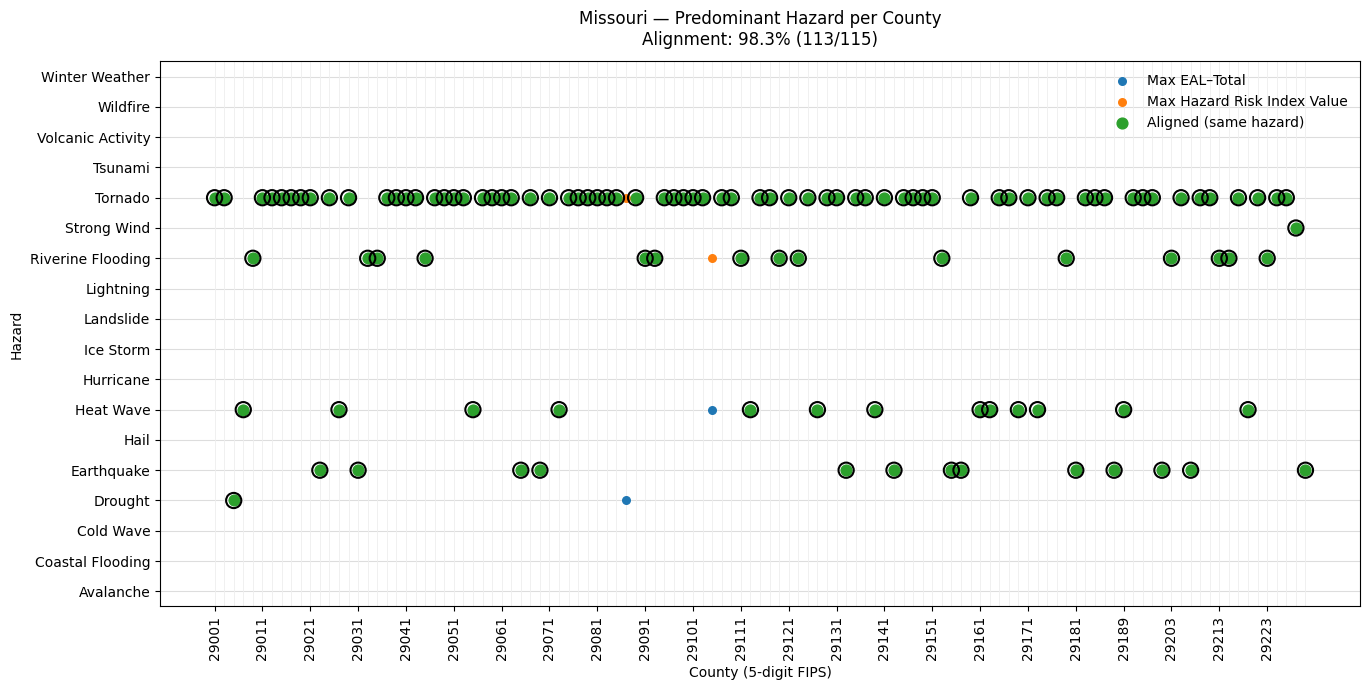

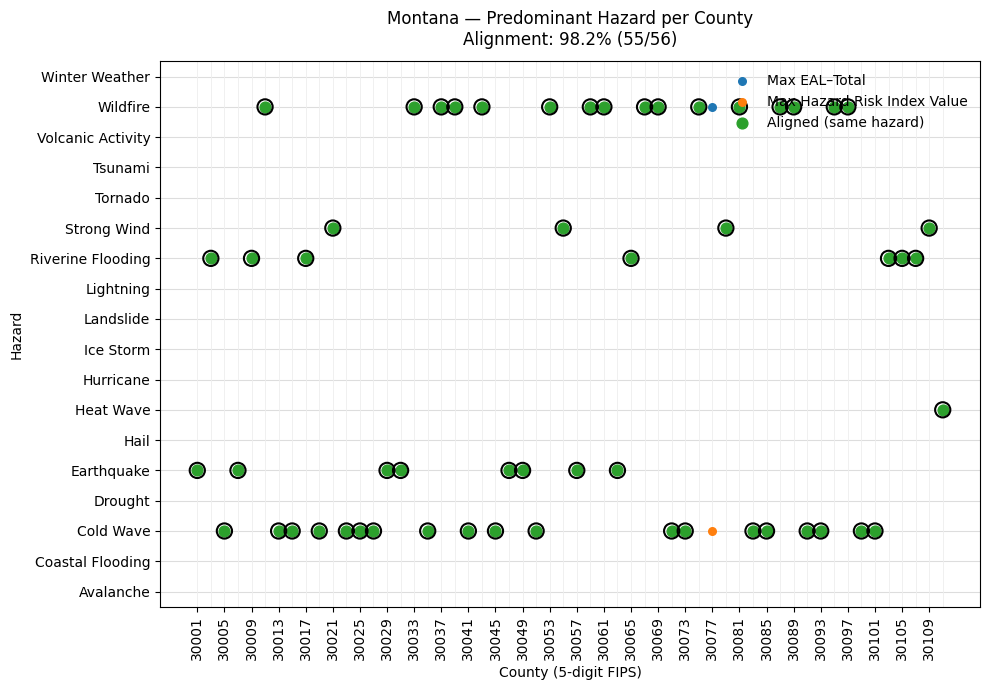

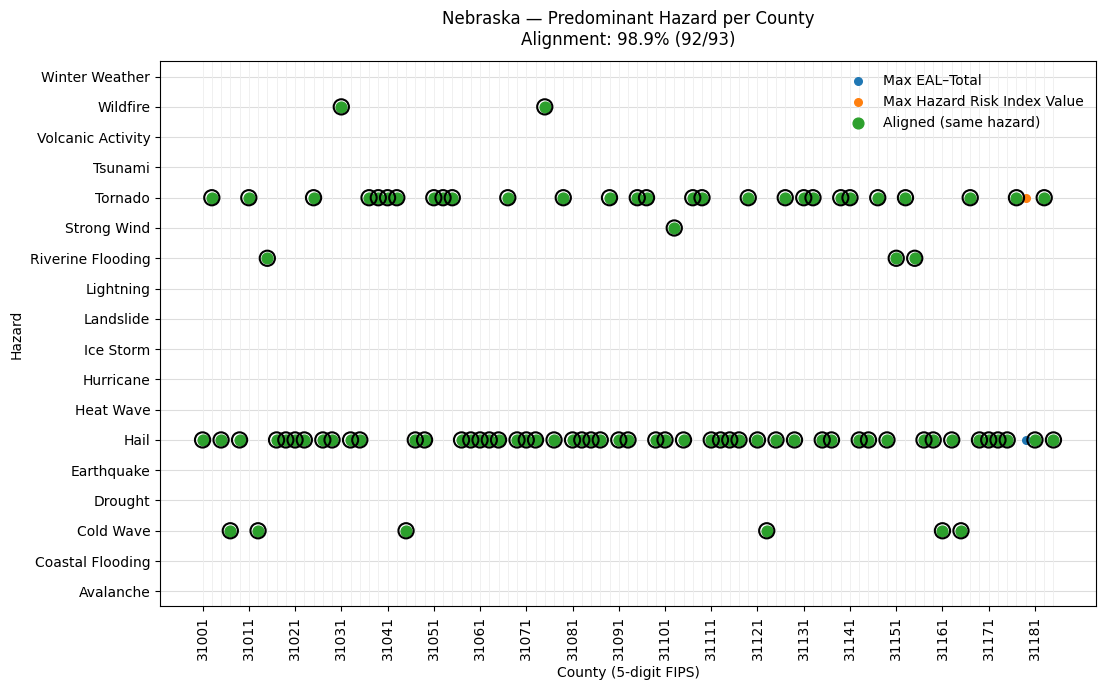

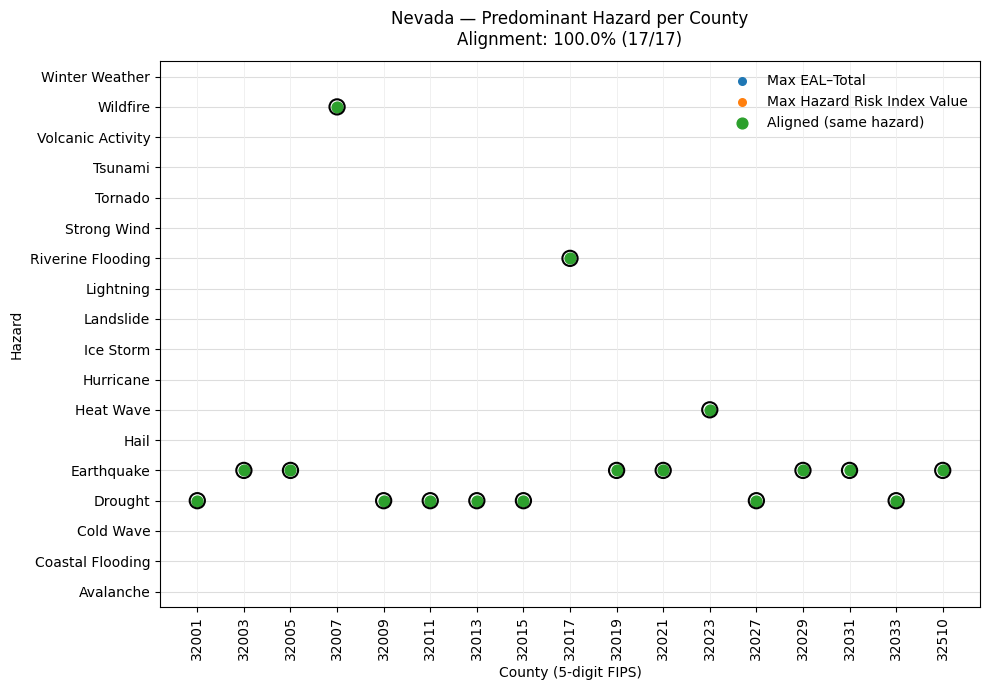

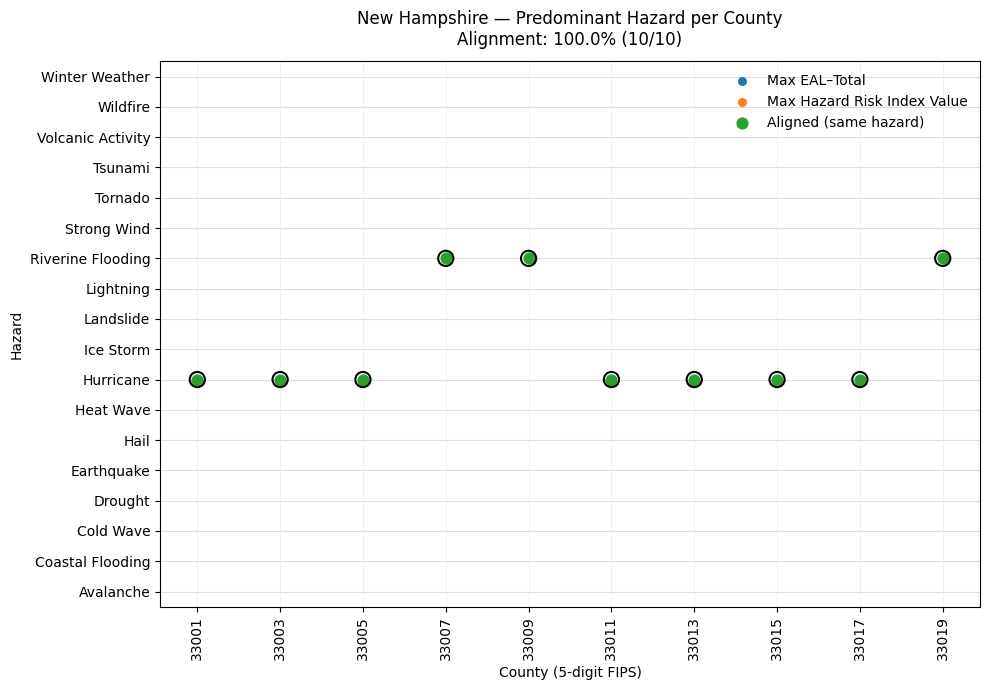

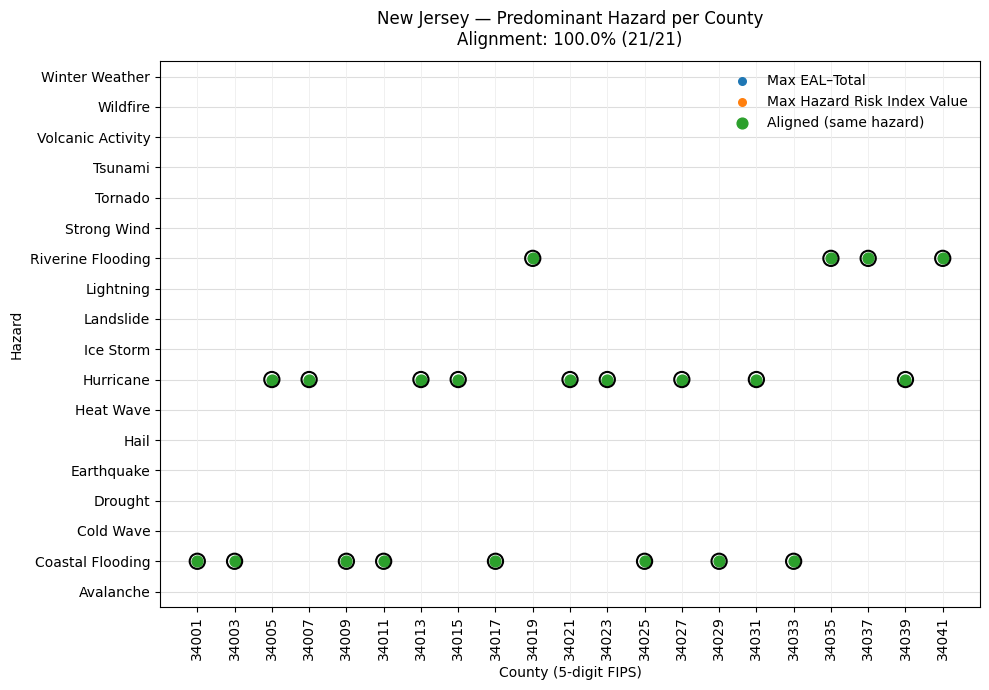

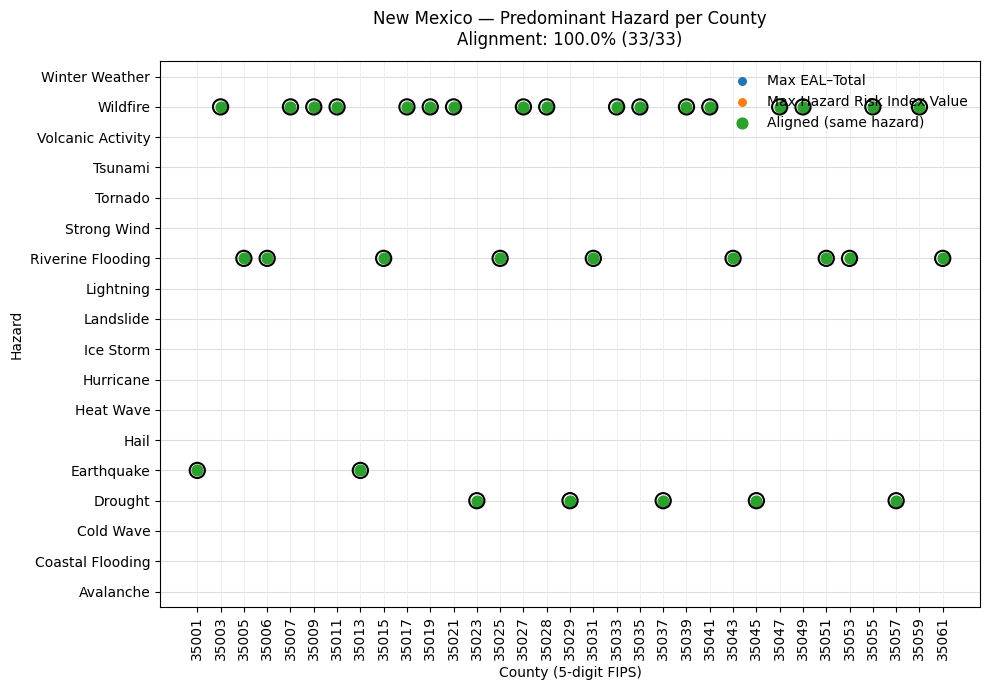

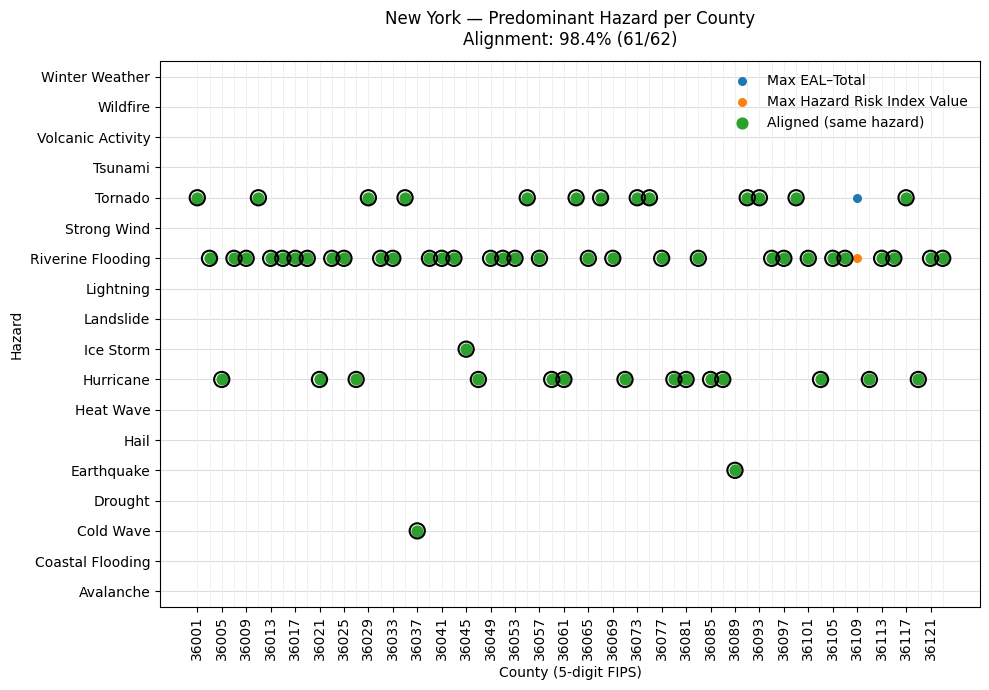

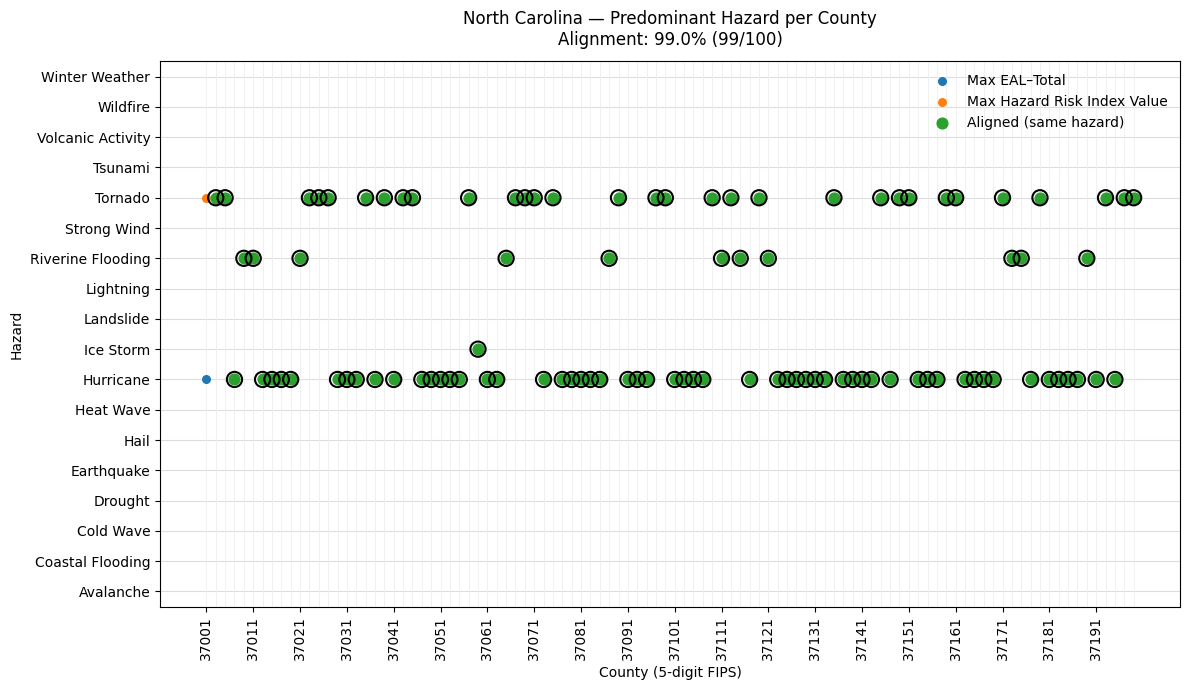

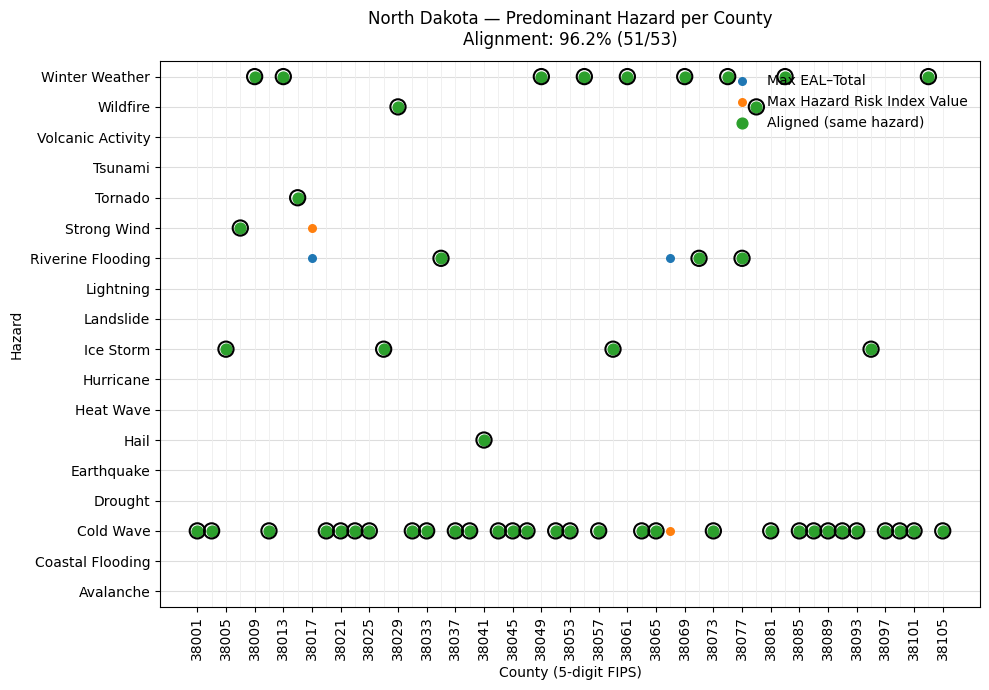

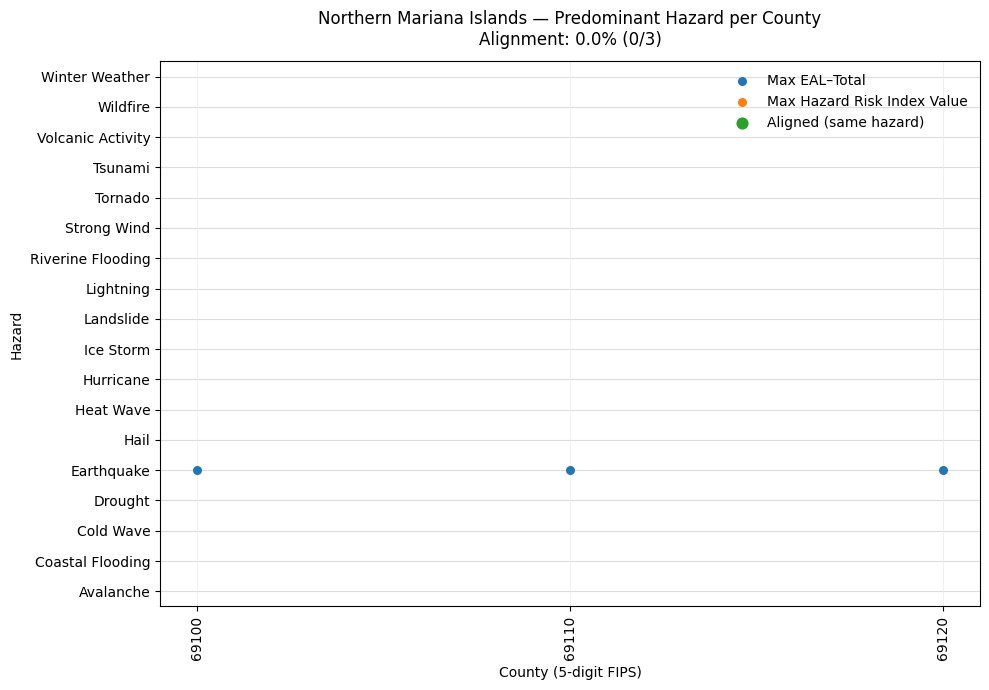

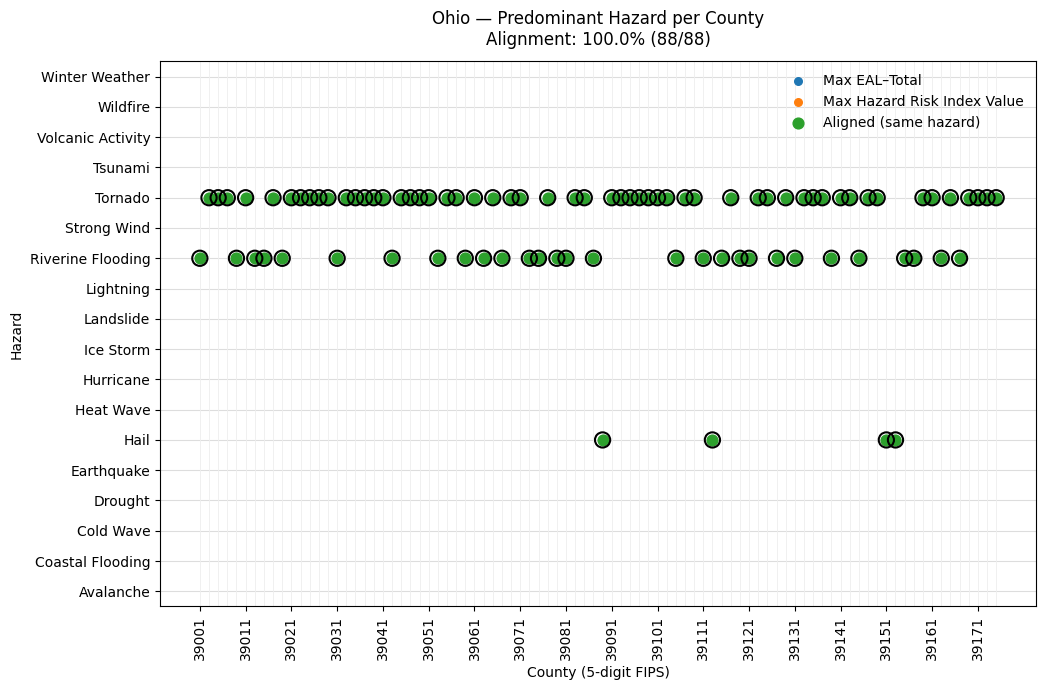

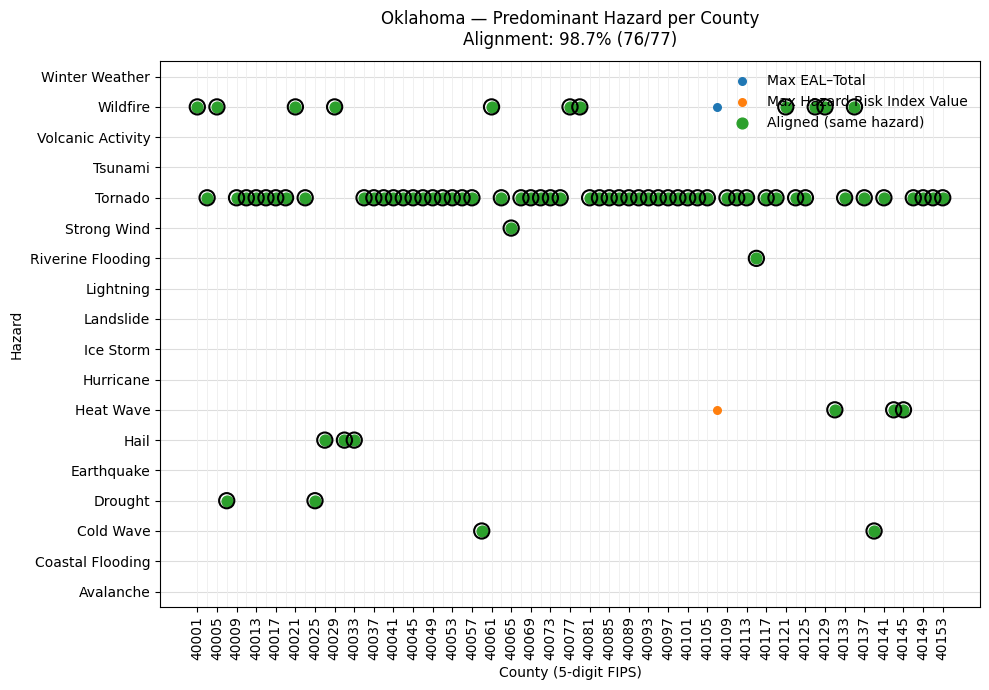

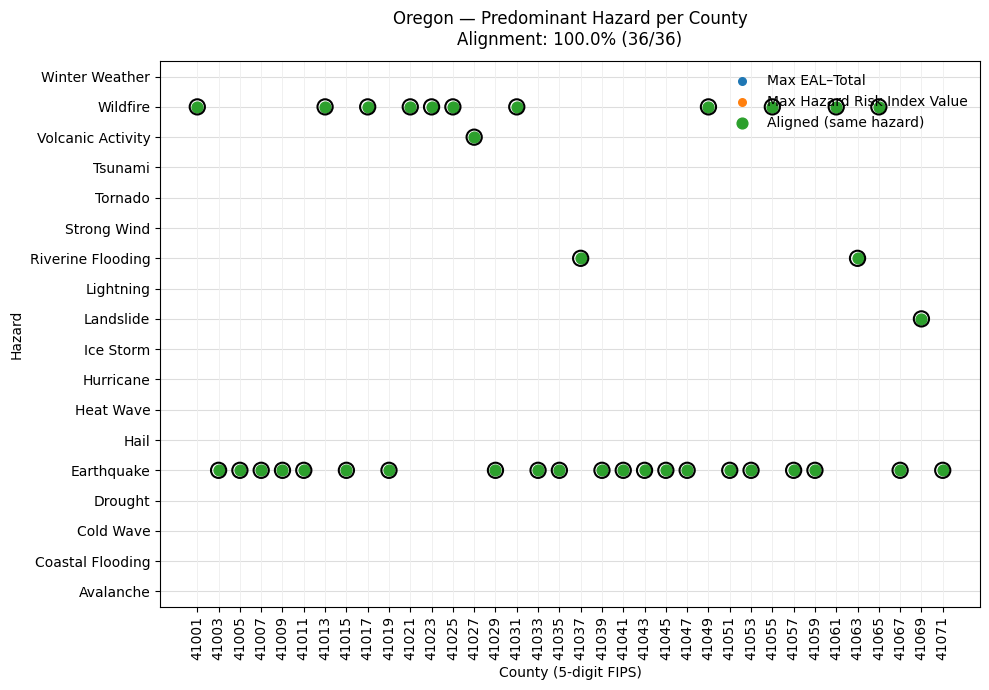

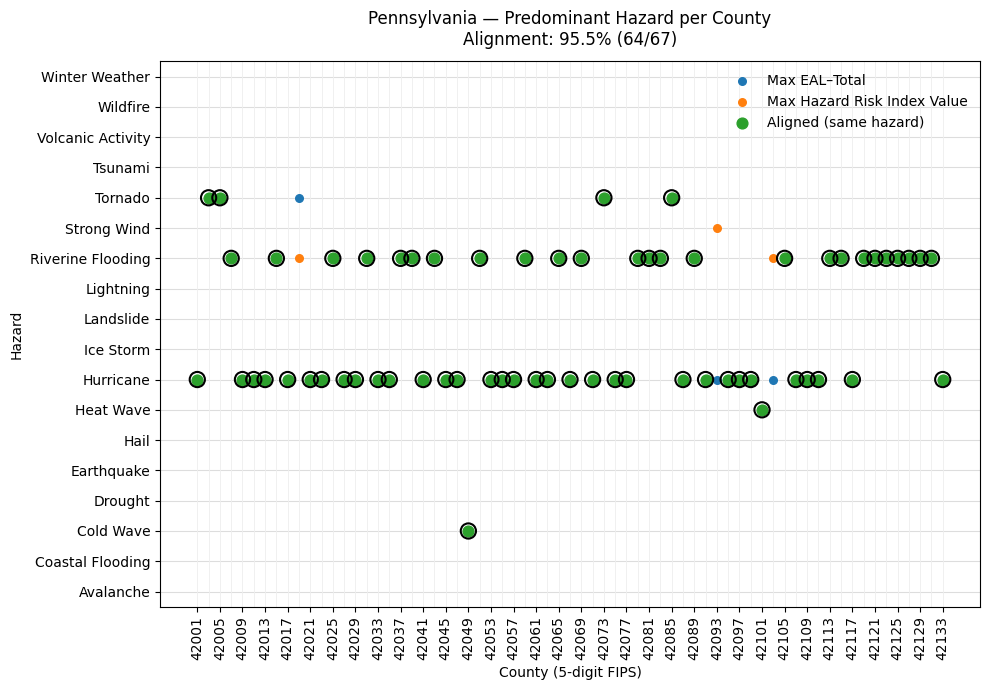

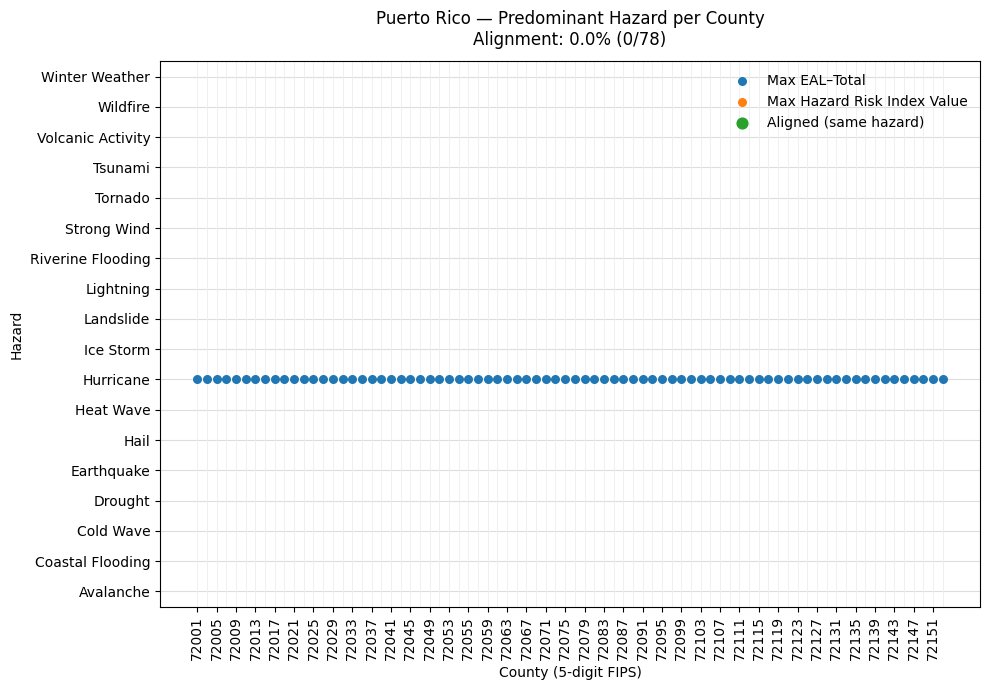

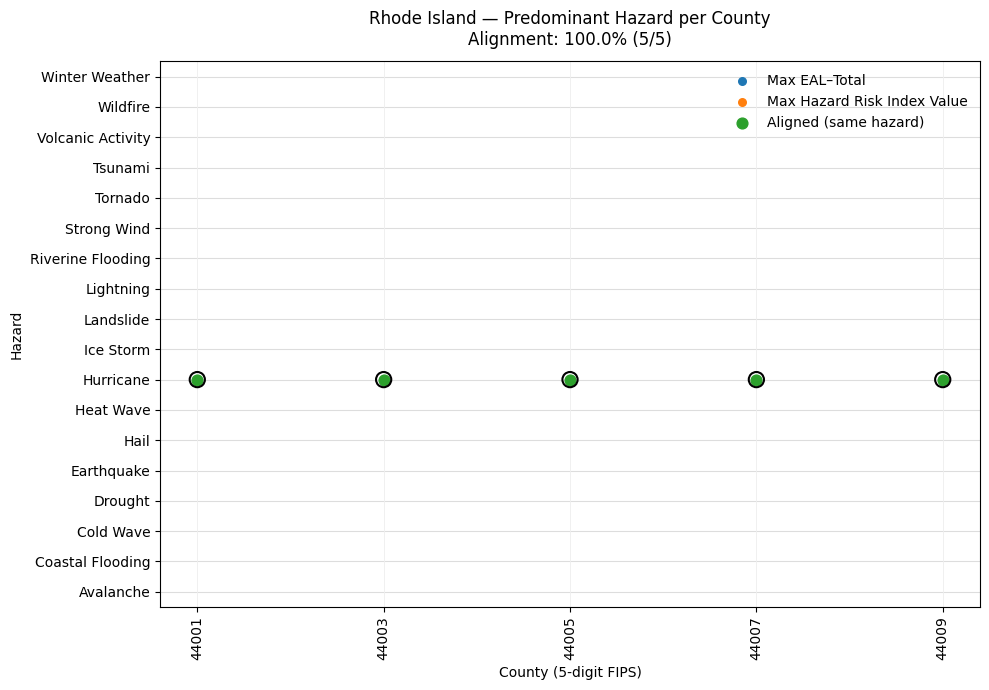

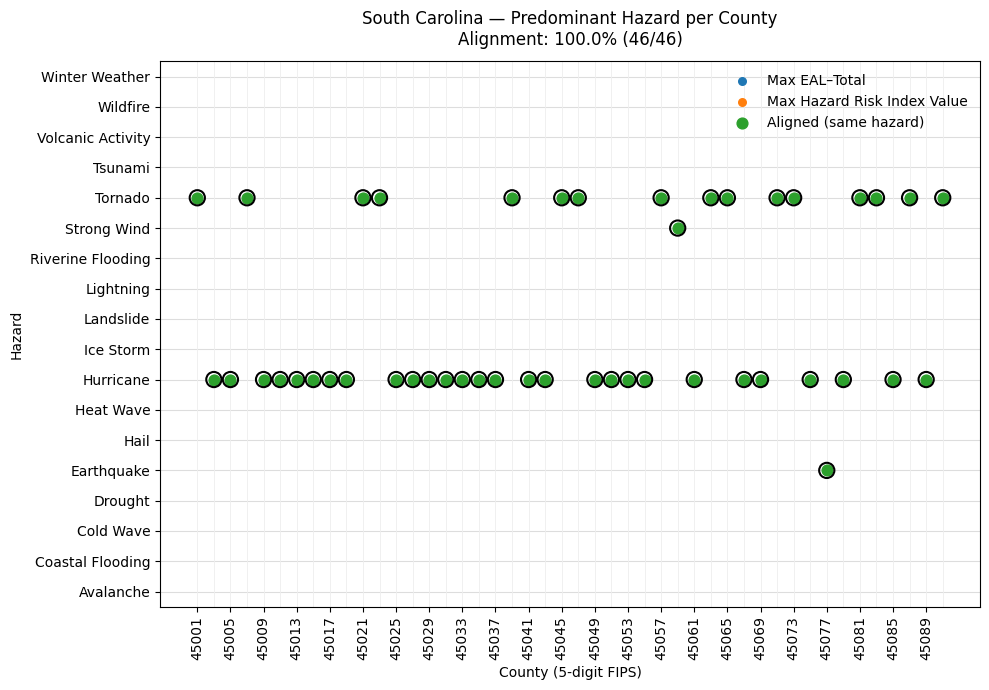

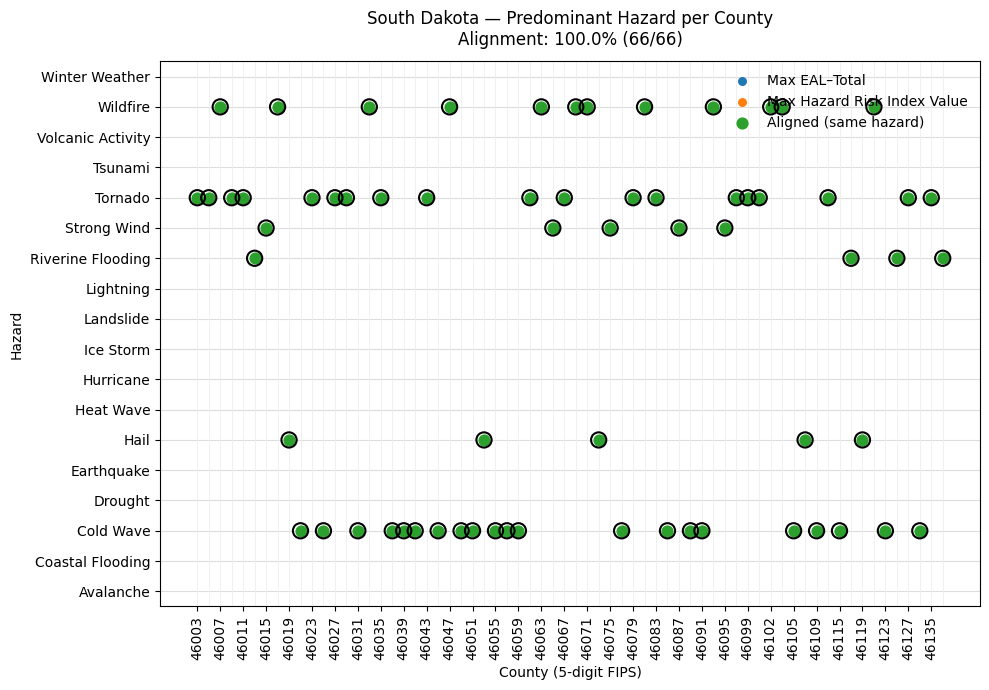

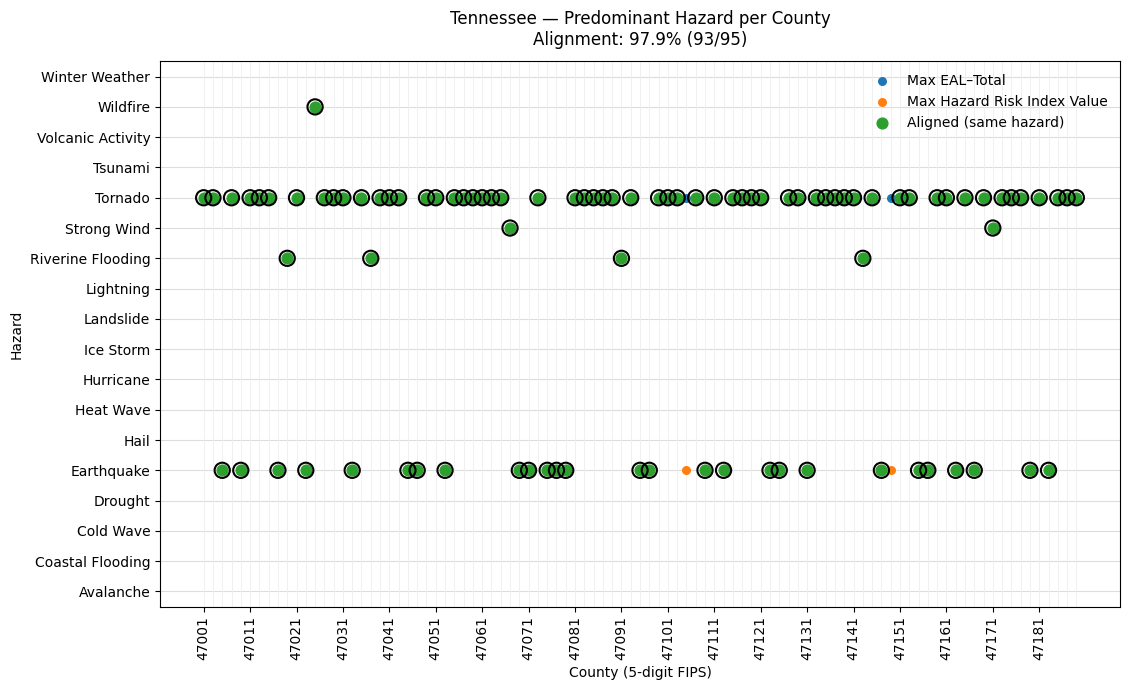

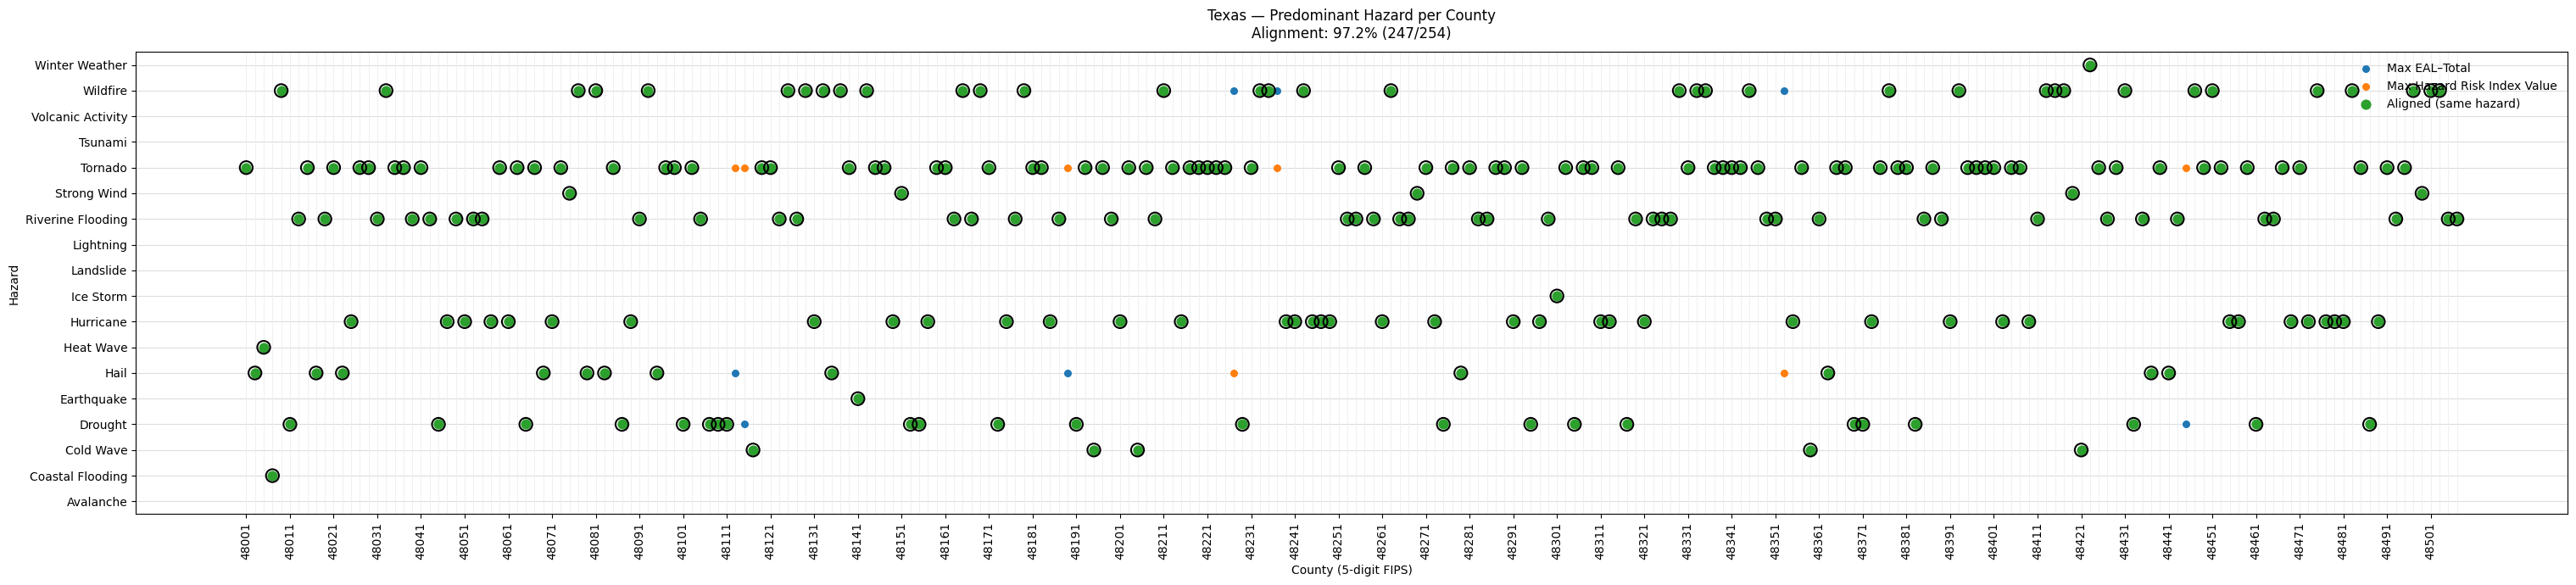

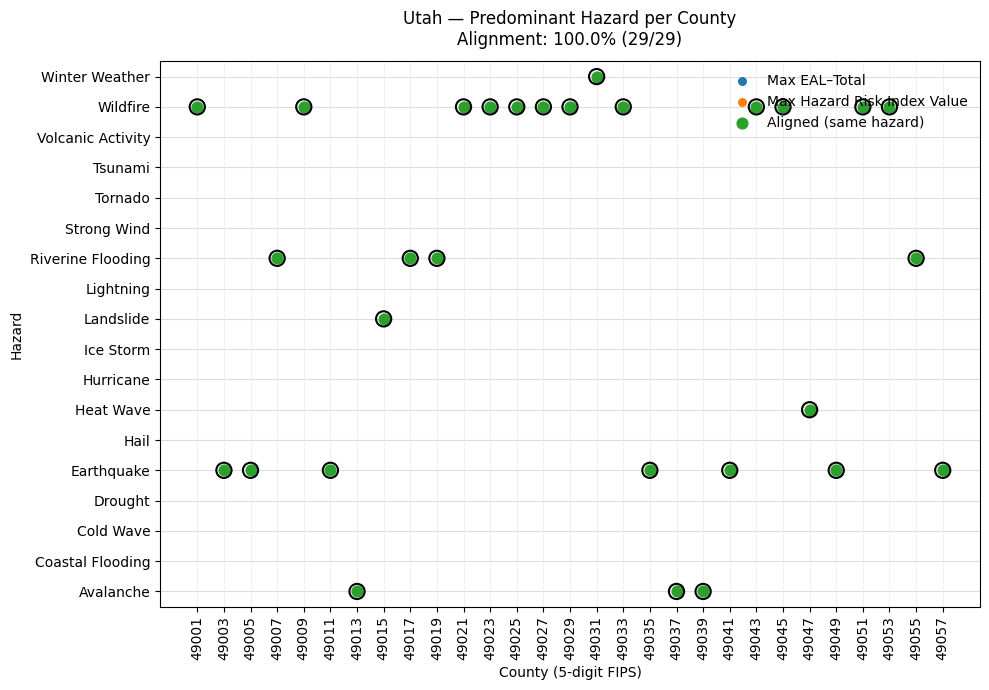

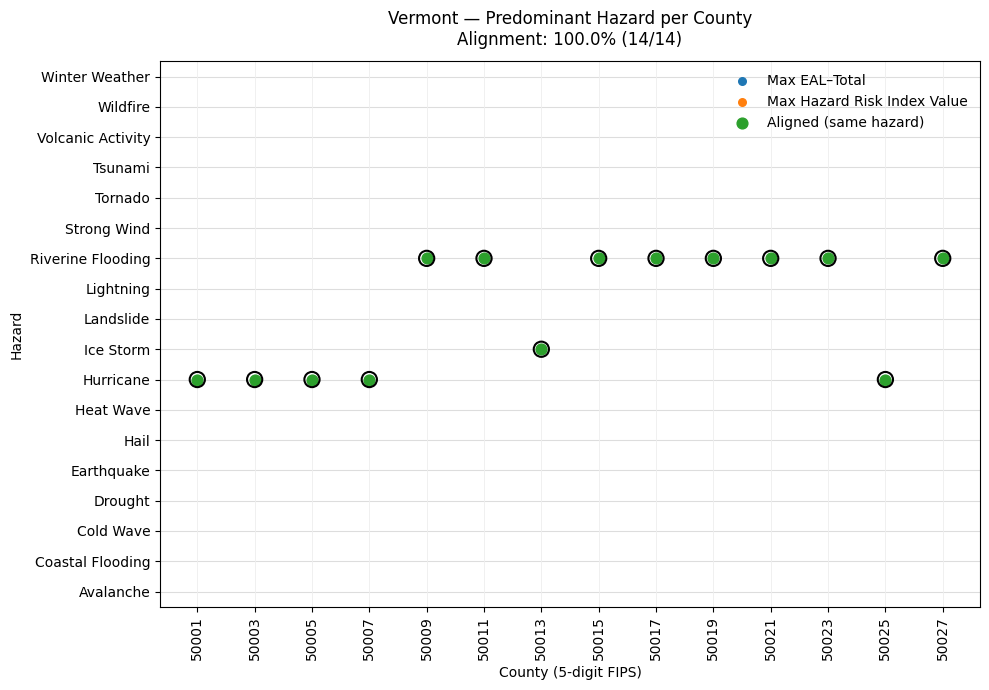

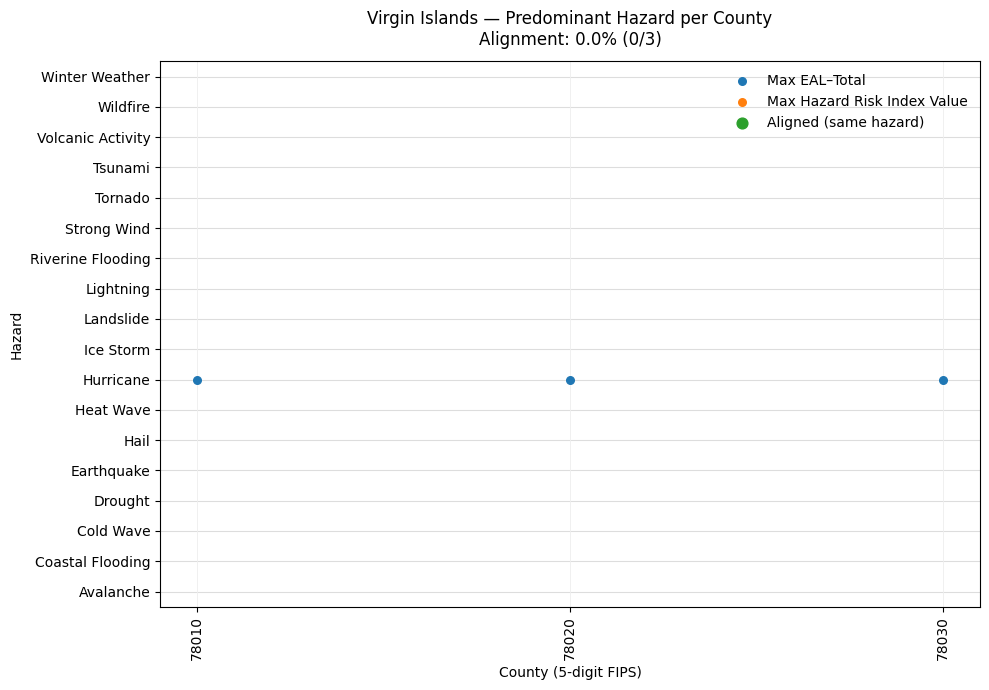

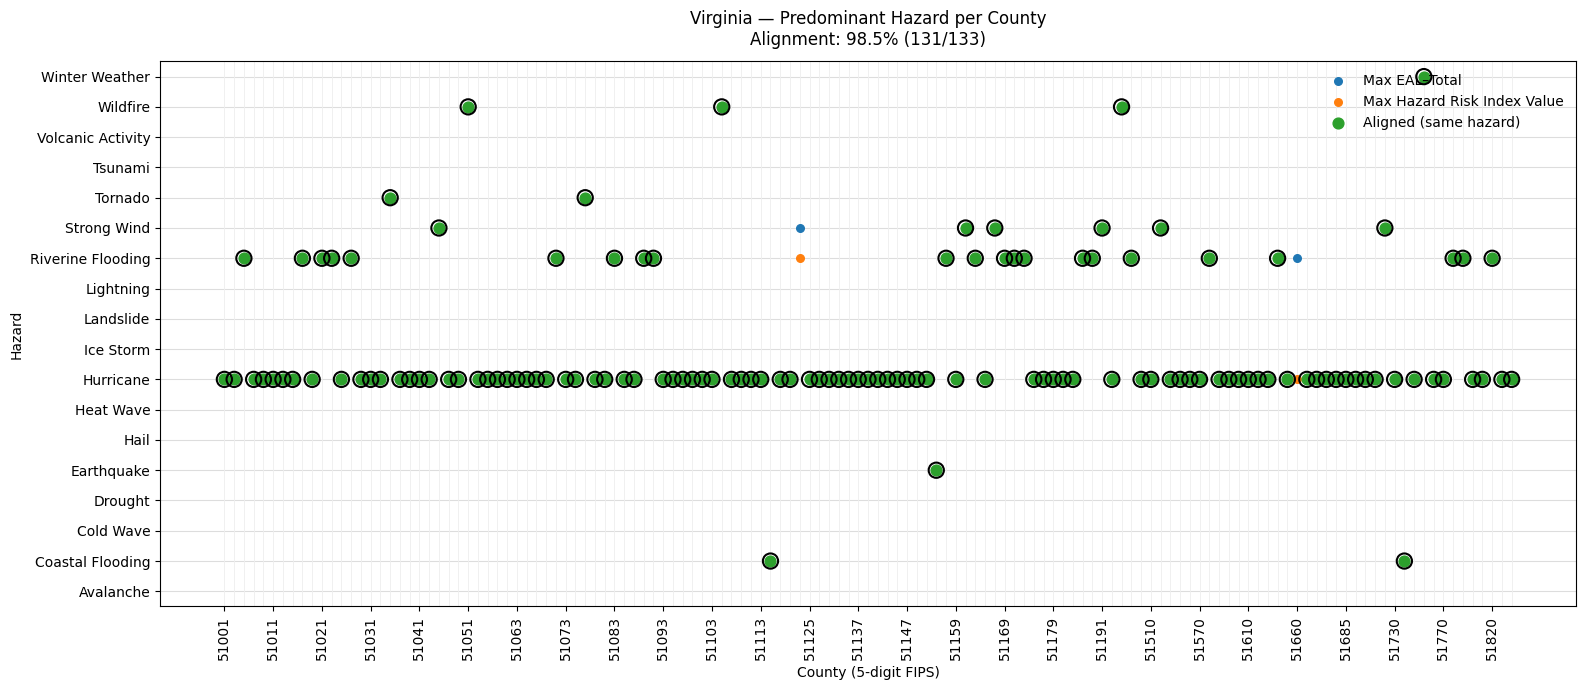

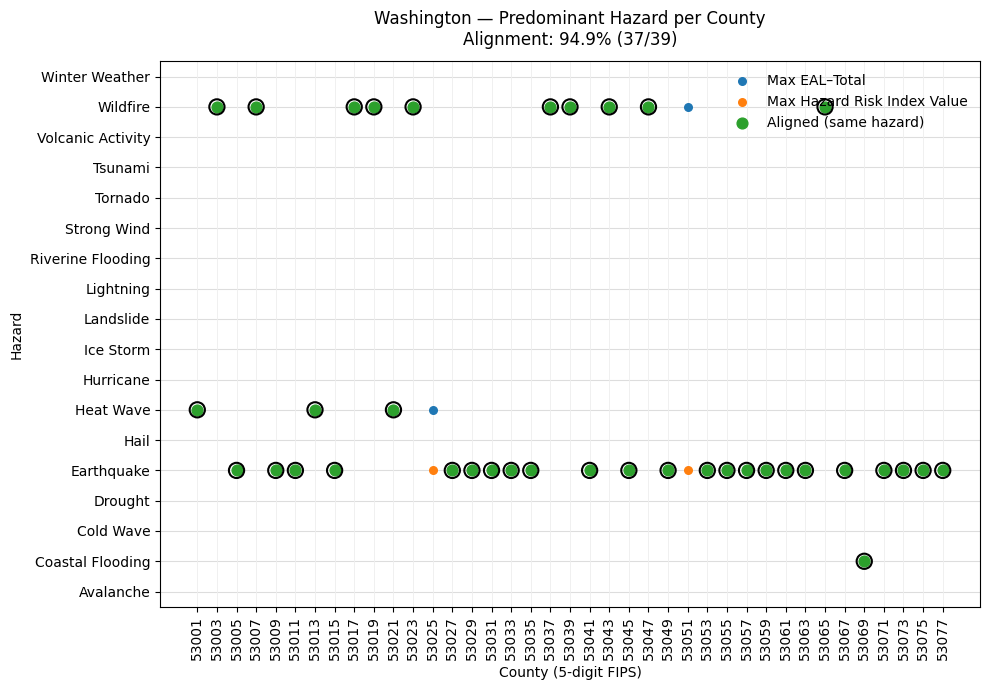

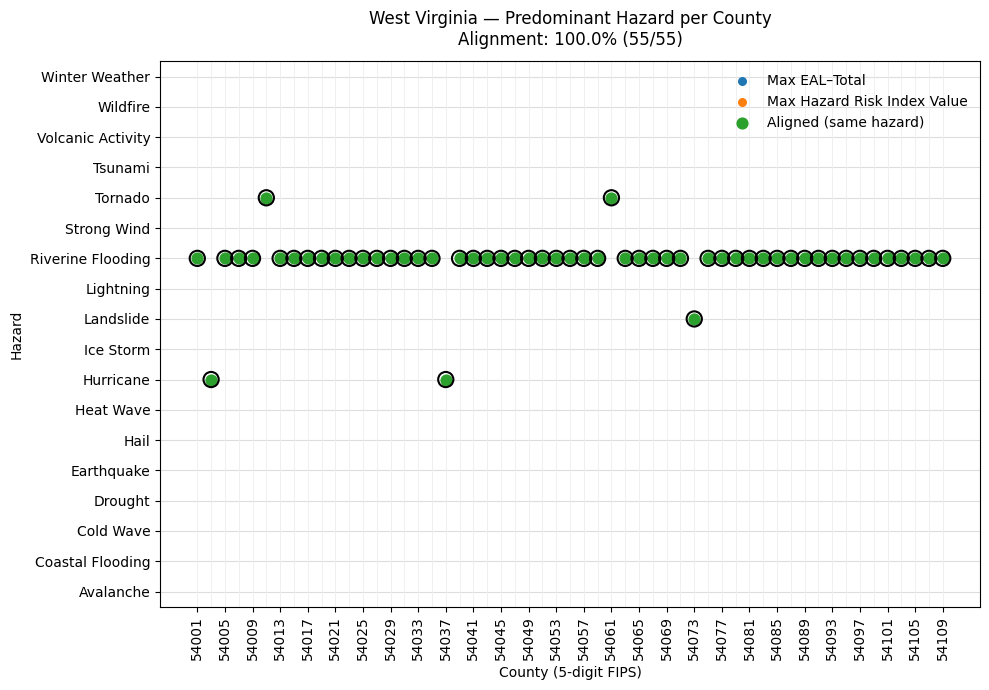

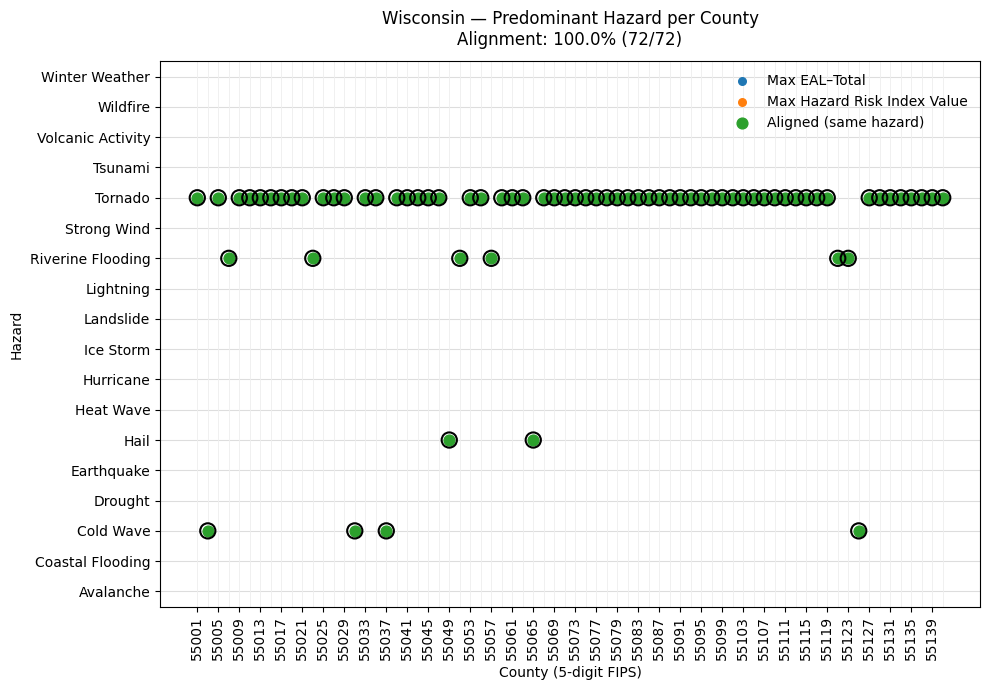

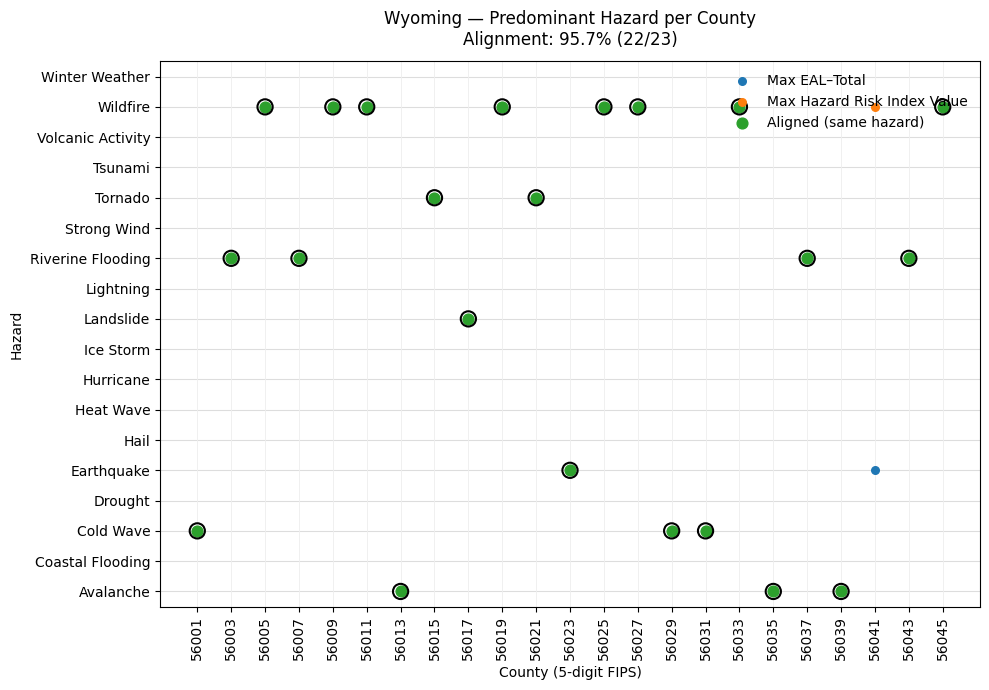

In [18]:
SHOW_LIMIT = None

shown = 0
for s in state_names:
    if SHOW_LIMIT is not None and shown >= SHOW_LIMIT:
        break

    sdf = df[df["State Name"] == s].copy()
    sdf = sdf.sort_values("county_fips")  # 5-digit FIPS order

    counties = sdf["county_fips"].tolist()
    x_idx = np.arange(len(counties))

    y_eal = [haz2y.get(h, np.nan) for h in sdf["predominant_hazard"]]
    y_riv = [haz2y.get(h, np.nan) for h in sdf["predominant_hazard_riskindex"]]

    align_mask = (sdf["predominant_hazard"] == sdf["predominant_hazard_riskindex"])
    align_pct = 100.0 * align_mask.mean()
    per_state_alignment.append((s, align_pct, align_mask.sum(), len(align_mask)))

    # ---- plot ----
    fig, ax = plt.subplots(figsize=(max(10, len(counties) * 0.12), 7))

    # horizontal lines for hazards
    for y in range(len(HAZARDS)):
        ax.axhline(y, color="#dddddd", linewidth=0.8, zorder=0)
    # vertical lines for each county
    for x in x_idx:
        ax.axvline(x, color="#eeeeee", linewidth=0.6, zorder=0)

    # --- scatter plots ---
    # non-aligned EAL–Total points
    ax.scatter(x_idx[~align_mask], np.array(y_eal)[~align_mask],
               s=30, color="tab:blue", label="Max EAL–Total", zorder=3)
    # non-aligned Risk Index Value points
    ax.scatter(x_idx[~align_mask], np.array(y_riv)[~align_mask],
               s=30, color="tab:orange", label="Max Hazard Risk Index Value", zorder=3)
    # aligned points: filled with green + black outline
    aligned_x = x_idx[align_mask.values]
    aligned_y = np.array(y_eal)[align_mask.values]
    ax.scatter(aligned_x, aligned_y, s=60, color="tab:green", label="Aligned (same hazard)", zorder=4)
    ax.scatter(aligned_x, aligned_y, s=120, facecolors='none', edgecolors='black',
               linewidths=1.5, zorder=5)

    # axes formatting
    ax.set_title(f"{s} — Predominant Hazard per County\nAlignment: {align_pct:.1f}% "
                 f"({align_mask.sum()}/{len(align_mask)})", pad=12)
    ax.set_ylabel("Hazard")
    ax.set_xlabel("County (5-digit FIPS)")
    ax.set_yticks(range(len(HAZARDS)))
    ax.set_yticklabels(HAZARDS)

    # x-ticks: subsample if too many counties
    N = 1 if len(counties) <= 40 else (2 if len(counties) <= 80 else 5)
    ax.set_xticks(x_idx[::N])
    ax.set_xticklabels([counties[i] for i in range(0, len(counties), N)], rotation=90)

    ax.set_ylim(-0.5, len(HAZARDS) - 0.5)
    ax.legend(loc="upper right", frameon=False)
    fig.tight_layout()

    plt.show()
    plt.close(fig)
    shown += 1


In [19]:
# --- Alignment summary after showing all plots ---
total_align = sum(c for _, _, c, _ in per_state_alignment)
total_cnt   = sum(n for _, _, _, n in per_state_alignment)
overall_pct = 100.0 * total_align / total_cnt if total_cnt else 0.0
print(f"\nOverall alignment across all counties: {overall_pct:.2f}% "
      f"({total_align}/{total_cnt})")



Overall alignment across all counties: 95.73% (3093/3231)
